In [16]:
import pandas as pd
import os

df = pd.DataFrame()
"""
for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)])
    print(f"Added {json_file} to dataframe.")
"""
df = pd.read_json('dataset/jsonl/en-US.jsonl', lines=True)

In [17]:
%run -i "preprocess_lang.ipynb"
%run -i "preprocess_nolang.ipynb"
%run -i "evaluation.ipynb"

In [18]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id
0,0,en-US,test,alarm,alarm_set,wake me up at five am this week,wake me up at [time : five am] [date : this week],1
1,1,en-US,train,alarm,alarm_set,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1
2,2,en-US,train,alarm,alarm_set,set an alarm for two hours from now,set an alarm for [time : two hours from now],1
3,3,en-US,test,audio,audio_volume_mute,quiet,quiet,1
4,4,en-US,train,audio,audio_volume_mute,olly quiet,olly quiet,1


In [19]:
from toolz.functoolz import pipe

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming
]


df = pipe(
    df,
    *params
)


df['utt'] = df['utt'].apply(lambda x: " ".join(x))
df, encoder = encode_labels(df)

print(f"Finished preprocessing dataset.\n\n")


Finished preprocessing dataset.




In [20]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,utt_text
0,0,en,test,alarm,2,wake me up at five am this week,wake me up at [time : five am] [date : this week],1,"(w, a, k, e, , m, e, , u, p, , a, t, , f, ..."
1,1,en,train,alarm,2,wake me up at nine am on friday,wake me up at [time : nine am] on [date : friday],1,"(w, a, k, e, , m, e, , u, p, , a, t, , n, ..."
2,2,en,train,alarm,2,set an alarm for two hour from now,set an alarm for [time : two hours from now],1,"(s, e, t, , a, n, , a, l, a, r, m, , f, o, ..."
3,3,en,test,audio,4,quiet,quiet,1,"(q, u, i, e, t)"
4,4,en,train,audio,4,olli quiet,olly quiet,1,"(o, l, l, y, , q, u, i, e, t)"


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

vectorizer = CountVectorizer()
vectorized = vectorizer.fit_transform(df['utt'].to_list())


In [22]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [23]:
count_vect_df = pd.DataFrame(vectorized.todense(), columns=input_cols)
df = pd.concat([df, count_vect_df], axis=1)

In [24]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [25]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [26]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [27]:
english_indices = testing_df.index[(testing_df['locale'] == 'en')].values

indices = {
    'en': english_indices,
}

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best params for MultinomialNB: {'model__alpha': 0.5}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.6997935402618228
Classification report
              precision    recall  f1-score   support

           0     0.8333    0.7353    0.7812        34
           1     0.9333    0.6667    0.7778        21
           2     0.8095    0.8293    0.8193        41
           3     1.0000    0.5455    0.7059        11
           4     0.9474    0.5625    0.7059        32
           5     1.0000    0.0000    0.0000         6
           6     0.4706    0.6154    0.5333        13
           7     0.6250    0.7937    0.6993       126
           8     0.8630    0.9403    0.9000        67
           9     0.7539    0.9234    0.8301       209
          11     0.9365    0.8194    0.8741        72
          12     1.0000    0.3333    0.5000        15
          13     0.7353    0.8523    0.7895        88
          14     0.8000    0.3333    0.4706        12
          

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


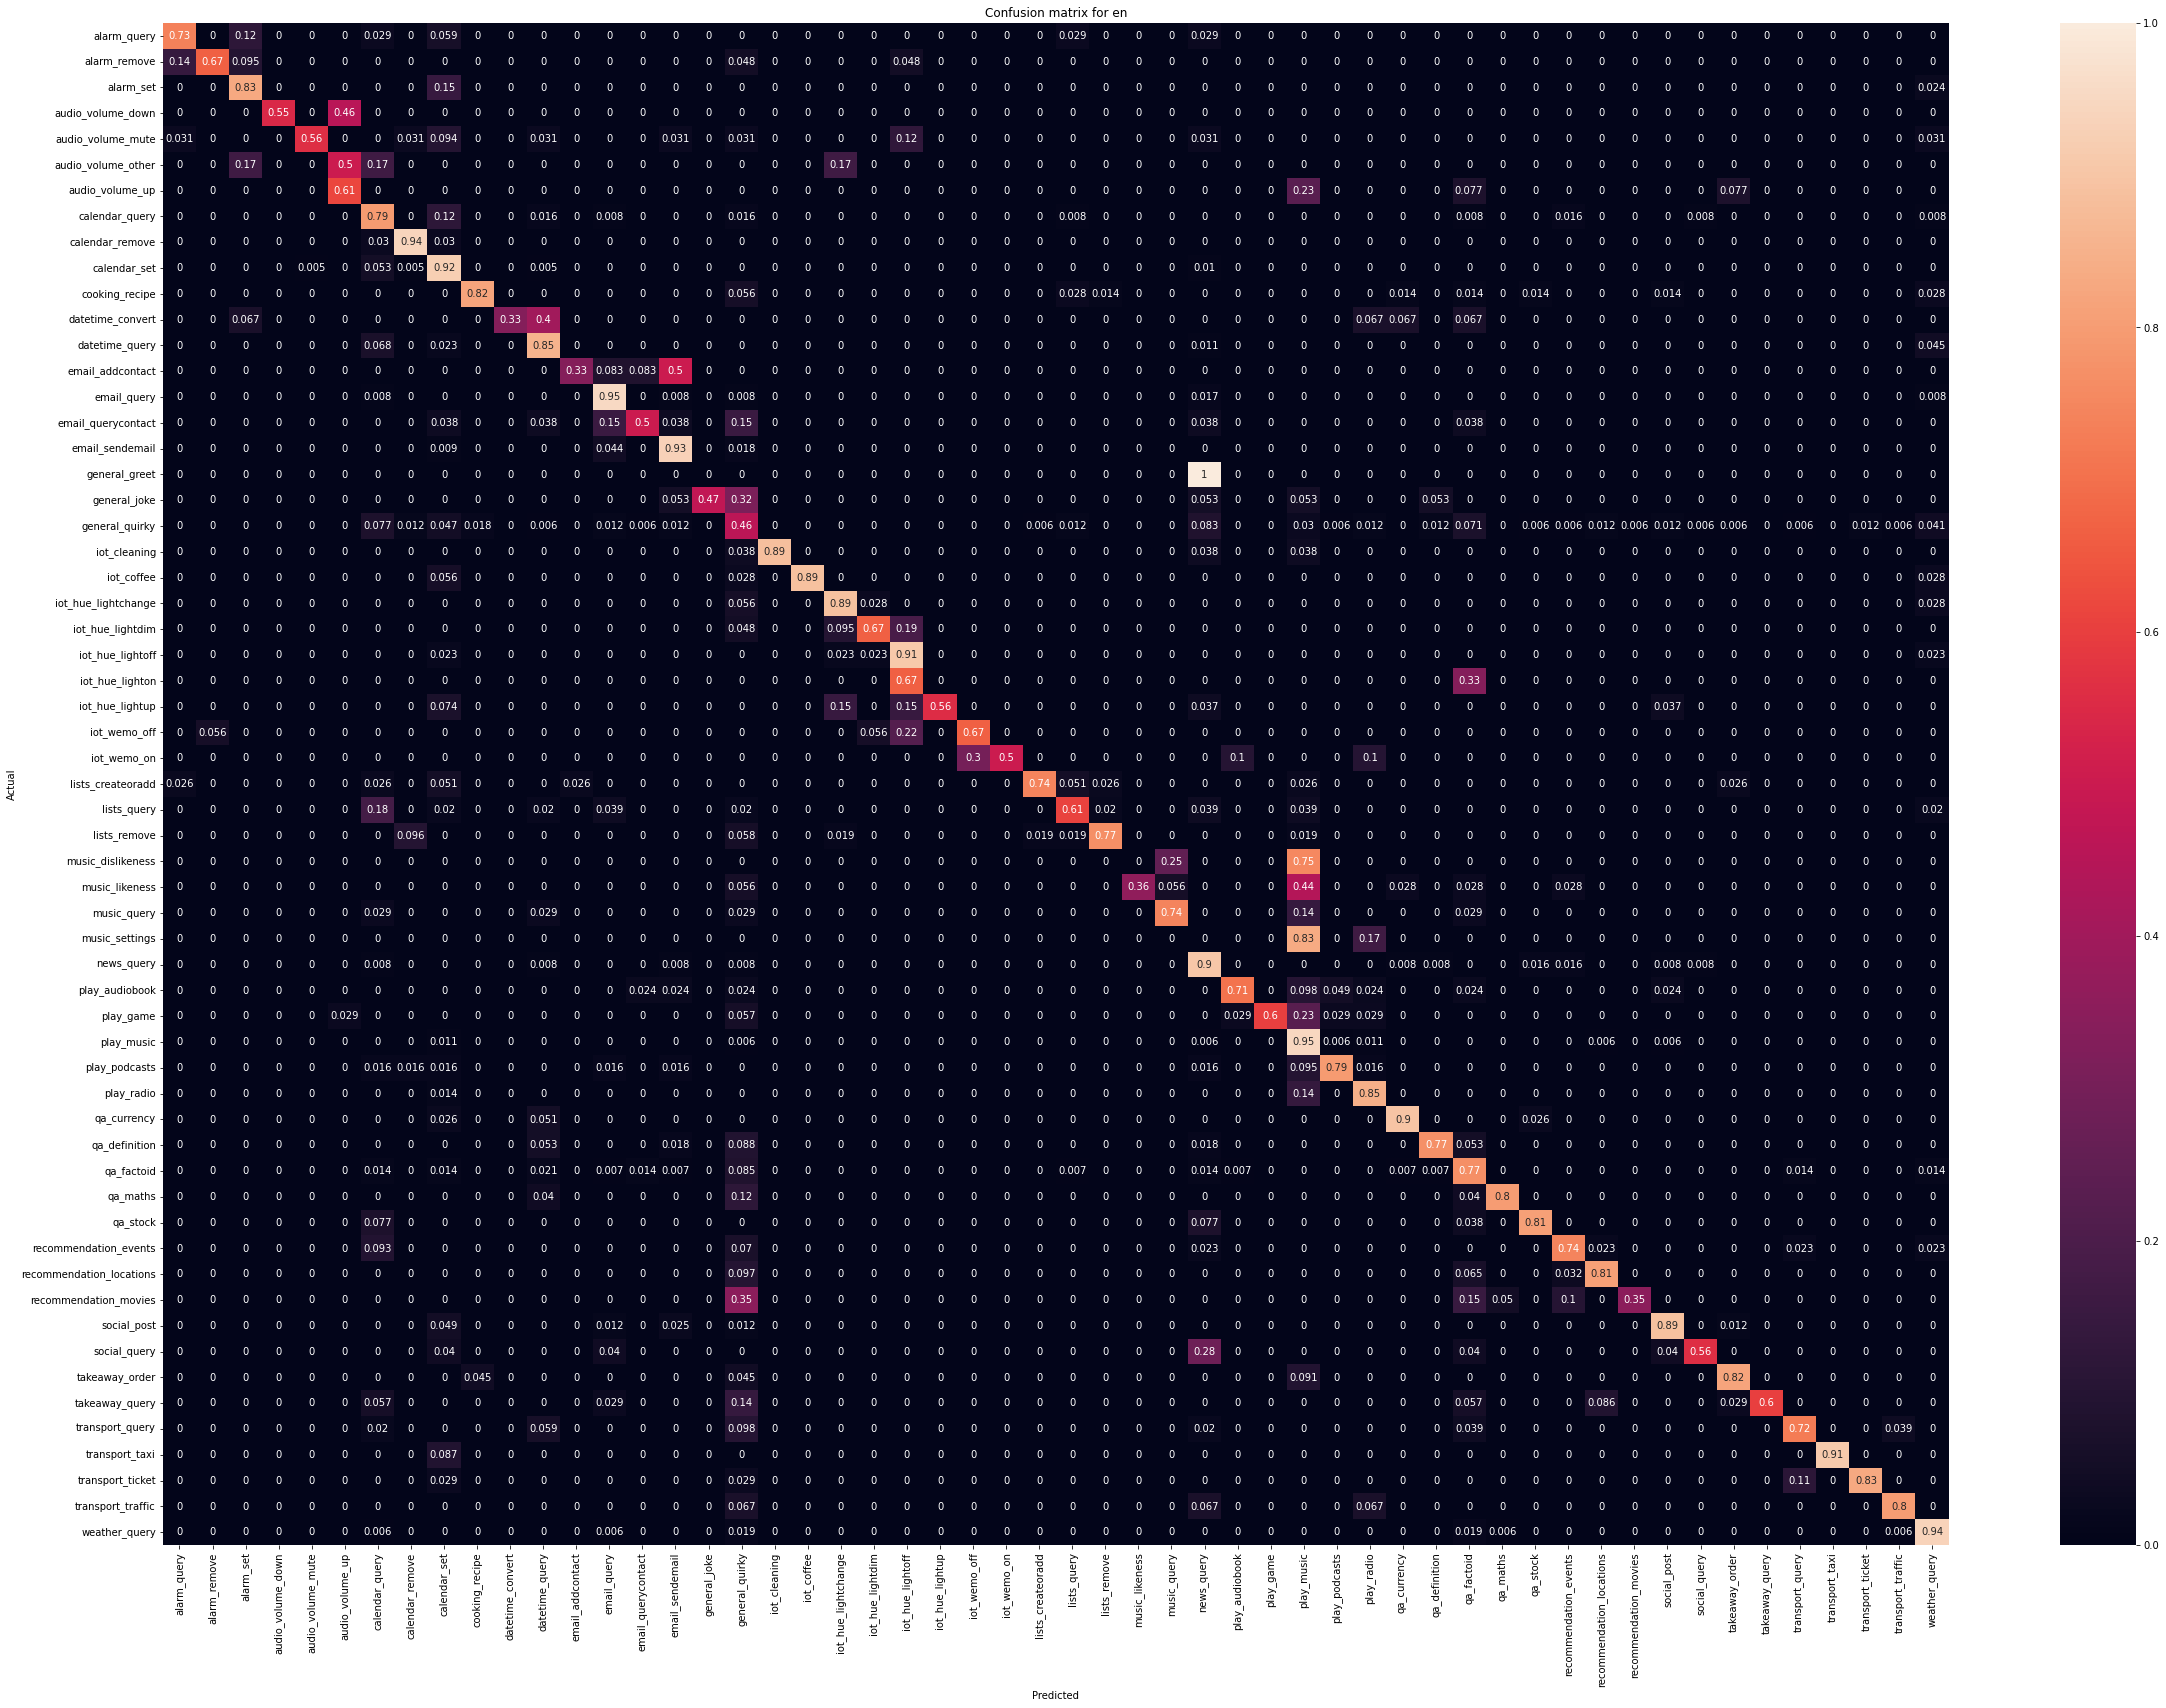

In [104]:
from sklearn.naive_bayes import MultinomialNB

nb = train_and_use_model(
    MultinomialNB(),
    {
        "model__alpha": [0.1, 0.5, 1.0, 1.5, 2.0],
    },
    n_iter=1,
    indices=indices,
    encoder=encoder,
)

# MultinomialNB

Best params:
{
    'model__alpha': 0.1
}

In [9]:
#import xgboost as xgb
import xgboost as xgb

xgboost = train_and_use_model(
    xgb.XGBClassifier(),
    {
        "model__n_estimators": [100, 200, 300, 400, 500],
        "model__max_depth": [3, 4, 5, 6, 7, 8, 9, 10],
        "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
        "model__booster": ["gbtree", "gblinear", "dart"],
        "model__gamma": [0, 0.25, 0.5, 1.0],
        "model__min_child_weight": [1, 3, 5, 7],
        "model__max_delta_step": [0, 0.2, 0.6, 1.0],
        "model__subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    },
    n_iter=3
)

C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
9 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\nrtc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\

[04:44:03] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.

Best params for XGBClassifier: {'model__subsample': 0.7, 'model__n_estimators': 200, 'model__min_child_weight': 3, 'model__max_depth': 3, 'model__max_delta_step': 1.0, 'model__learning_rate': 0.05, 'model__gamma': 0.5, 'model__booster': 'gblinear'}
Evaluation metrics for RandomizedSearchCV
RandomizedSearchCV's default score metric: 0.7887292811188353
Classification report
              precision    recall  f1-score   support

           0     0.9032    0.8235    0.8615        34
           1     0.9474    0.8571    0.9000        21
           2     0.7907    0.8293    0.8095        41
           3     0.8182    0.8182    0.8182        11
           4     0.8333    0.9375    0.8824        32
           5     1.0000    0.3333    0.50

# XGBoost

Best Params:
{
    'model__subsample': 0.7,
    'model__n_estimators': 200, 
    'model__min_child_weight': 3, 
    'model__max_depth': 3, 
    'model__max_delta_step': 1.0, 
    'model__learning_rate': 0.05, 
    'model__gamma': 0.5, 
    'model__booster': 'gblinear'
}

In [28]:
from sklearn.linear_model import LogisticRegression

knn = train_and_use_model(
    LogisticRegression(),
    {
        "model__penalty": ['l2', None],
        "model__solver": ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
        "model__C": [0.1, 0.5, 1.0, 1.5, 2.0],
        "model__max_iter": [100, 200, 300, 400, 500],
        "model__class_weight": ['balanced', None]
    },
    n_iter=1
)

# Logistic Regression

Best Params:
{
    'model__penalty': 0.7,
    'model__solver': 200, 
    'model__C': 3, 
    'model__max_iter': 3, 
    'model__class_weight': 1.0
}

In [1]:
import os
import pandas as pd

df = pd.DataFrame()

for json_file in os.listdir("dataset/jsonl/"):
    df = pd.concat([df, pd.read_json("dataset/jsonl/" + json_file, lines=True)], ignore_index=True)
    print(f"Added {json_file} to dataframe.")

df["locale"] = df["locale"].apply(lambda x: x.split("-")[0])

Added af-ZA.jsonl to dataframe.
Added am-ET.jsonl to dataframe.
Added ar-SA.jsonl to dataframe.
Added az-AZ.jsonl to dataframe.
Added bn-BD.jsonl to dataframe.
Added cy-GB.jsonl to dataframe.
Added da-DK.jsonl to dataframe.
Added de-DE.jsonl to dataframe.
Added el-GR.jsonl to dataframe.
Added en-US.jsonl to dataframe.
Added es-ES.jsonl to dataframe.
Added fa-IR.jsonl to dataframe.
Added fi-FI.jsonl to dataframe.
Added fr-FR.jsonl to dataframe.
Added he-IL.jsonl to dataframe.
Added hi-IN.jsonl to dataframe.
Added hu-HU.jsonl to dataframe.
Added hy-AM.jsonl to dataframe.
Added id-ID.jsonl to dataframe.
Added is-IS.jsonl to dataframe.
Added it-IT.jsonl to dataframe.
Added ja-JP.jsonl to dataframe.
Added jv-ID.jsonl to dataframe.
Added ka-GE.jsonl to dataframe.
Added km-KH.jsonl to dataframe.
Added kn-IN.jsonl to dataframe.
Added ko-KR.jsonl to dataframe.
Added lv-LV.jsonl to dataframe.
Added ml-IN.jsonl to dataframe.
Added mn-MN.jsonl to dataframe.
Added ms-MY.jsonl to dataframe.
Added my

In [2]:
df.head()

,id,locale,partition,scenario,intent,utt,annot_utt,worker_id,slot_method,judgments
0,0,af,test,alarm,alarm_set,maak my wakker om vyf v. m. die week,maak my wakker om [time : vyf v. m.] [date : d...,37,"[{'slot': 'time', 'method': 'localization'}, {...","[{'worker_id': '20', 'intent_score': 1, 'slots..."
1,1,af,train,alarm,alarm_set,maak my wakker nege-uur v. m. op vrydag,maak my wakker [time : nege-uur v. m.] op [dat...,20,"[{'slot': 'time', 'method': 'translation'}, {'...","[{'worker_id': '40', 'intent_score': 1, 'slots..."
2,2,af,train,alarm,alarm_set,stel 'n alarm vir twee ure van nou af,stel 'n alarm vir [time : twee ure van nou af],20,"[{'slot': 'time', 'method': 'translation'}]","[{'worker_id': '64', 'intent_score': 1, 'slots..."
3,3,af,test,audio,audio_volume_mute,stil,stil,40,[],"[{'worker_id': '45', 'intent_score': 1, 'slots..."
4,4,af,train,audio,audio_volume_mute,janneman stilte,janneman stilte,40,[],"[{'worker_id': '45', 'intent_score': 1, 'slots..."


In [5]:
from toolz.functoolz import pipe

params = [
    remove_punctuation,
    lowercase,
    tokenize,
    apply_stemming,
]

df = pipe(
    df,
    *params
)

df, encoder = encode_labels(df)

df['utt'] = df['utt'].apply(lambda x: " ".join(x))

print(f"Finished preprocessing dataset.\n\n")



Finished preprocessing dataset.




In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(df[df['partition'] != 'test']['utt'].values)

TfidfVectorizer()

In [7]:
input_cols = [f'__{feature_name}' for feature_name in vectorizer.get_feature_names_out()]
output_cols = ['intent']
averages = [None, "macro", "weighted", "micro", "samples"]

In [8]:
training_df = df[df['partition'] != 'test']
testing_df = df[df['partition'] == 'test']

In [9]:
training_df.reset_index(drop=True, inplace=True)
testing_df.reset_index(drop=True, inplace=True)

In [10]:
training_inputs = vectorizer.transform(training_df['utt'].values)
testing_inputs = vectorizer.transform(testing_df['utt'].values)
training_classes = training_df[output_cols].values.reshape(-1)
testing_classes = testing_df[output_cols].values.reshape(-1)

In [11]:
indices = {}

for lang in testing_df['locale'].unique():
    indices[lang] = testing_df.index[(testing_df['locale'] == lang)].values

In [12]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=0.5)

nb.fit(training_inputs, training_classes)


MultinomialNB(alpha=0.5)

Evaluation metrics for MultinomialNB
MultinomialNB's default score metric: 0.6546804330340071
Classification report
              precision    recall  f1-score   support

           0     0.9439    0.4072    0.5689      1734
           1     0.9917    0.2232    0.3643      1071
           2     0.6966    0.4161    0.5210      2091
           3     0.9674    0.3708    0.5361       561
           4     0.9365    0.3793    0.5399      1632
           5     1.0000    0.0000    0.0000       306
           6     0.4718    0.4419    0.4564       663
           7     0.4327    0.6643    0.5240      6426
           8     0.7739    0.6930    0.7312      3417
           9     0.4200    0.9461    0.5817     10659
          11     0.9561    0.5931    0.7321      3672
          12     1.0000    0.0131    0.0258       765
          13     0.7696    0.7779    0.7737      4488
          14     0.7647    0.0212    0.0413       612
          15     0.7641    0.9058    0.8289      6069
          16     0.

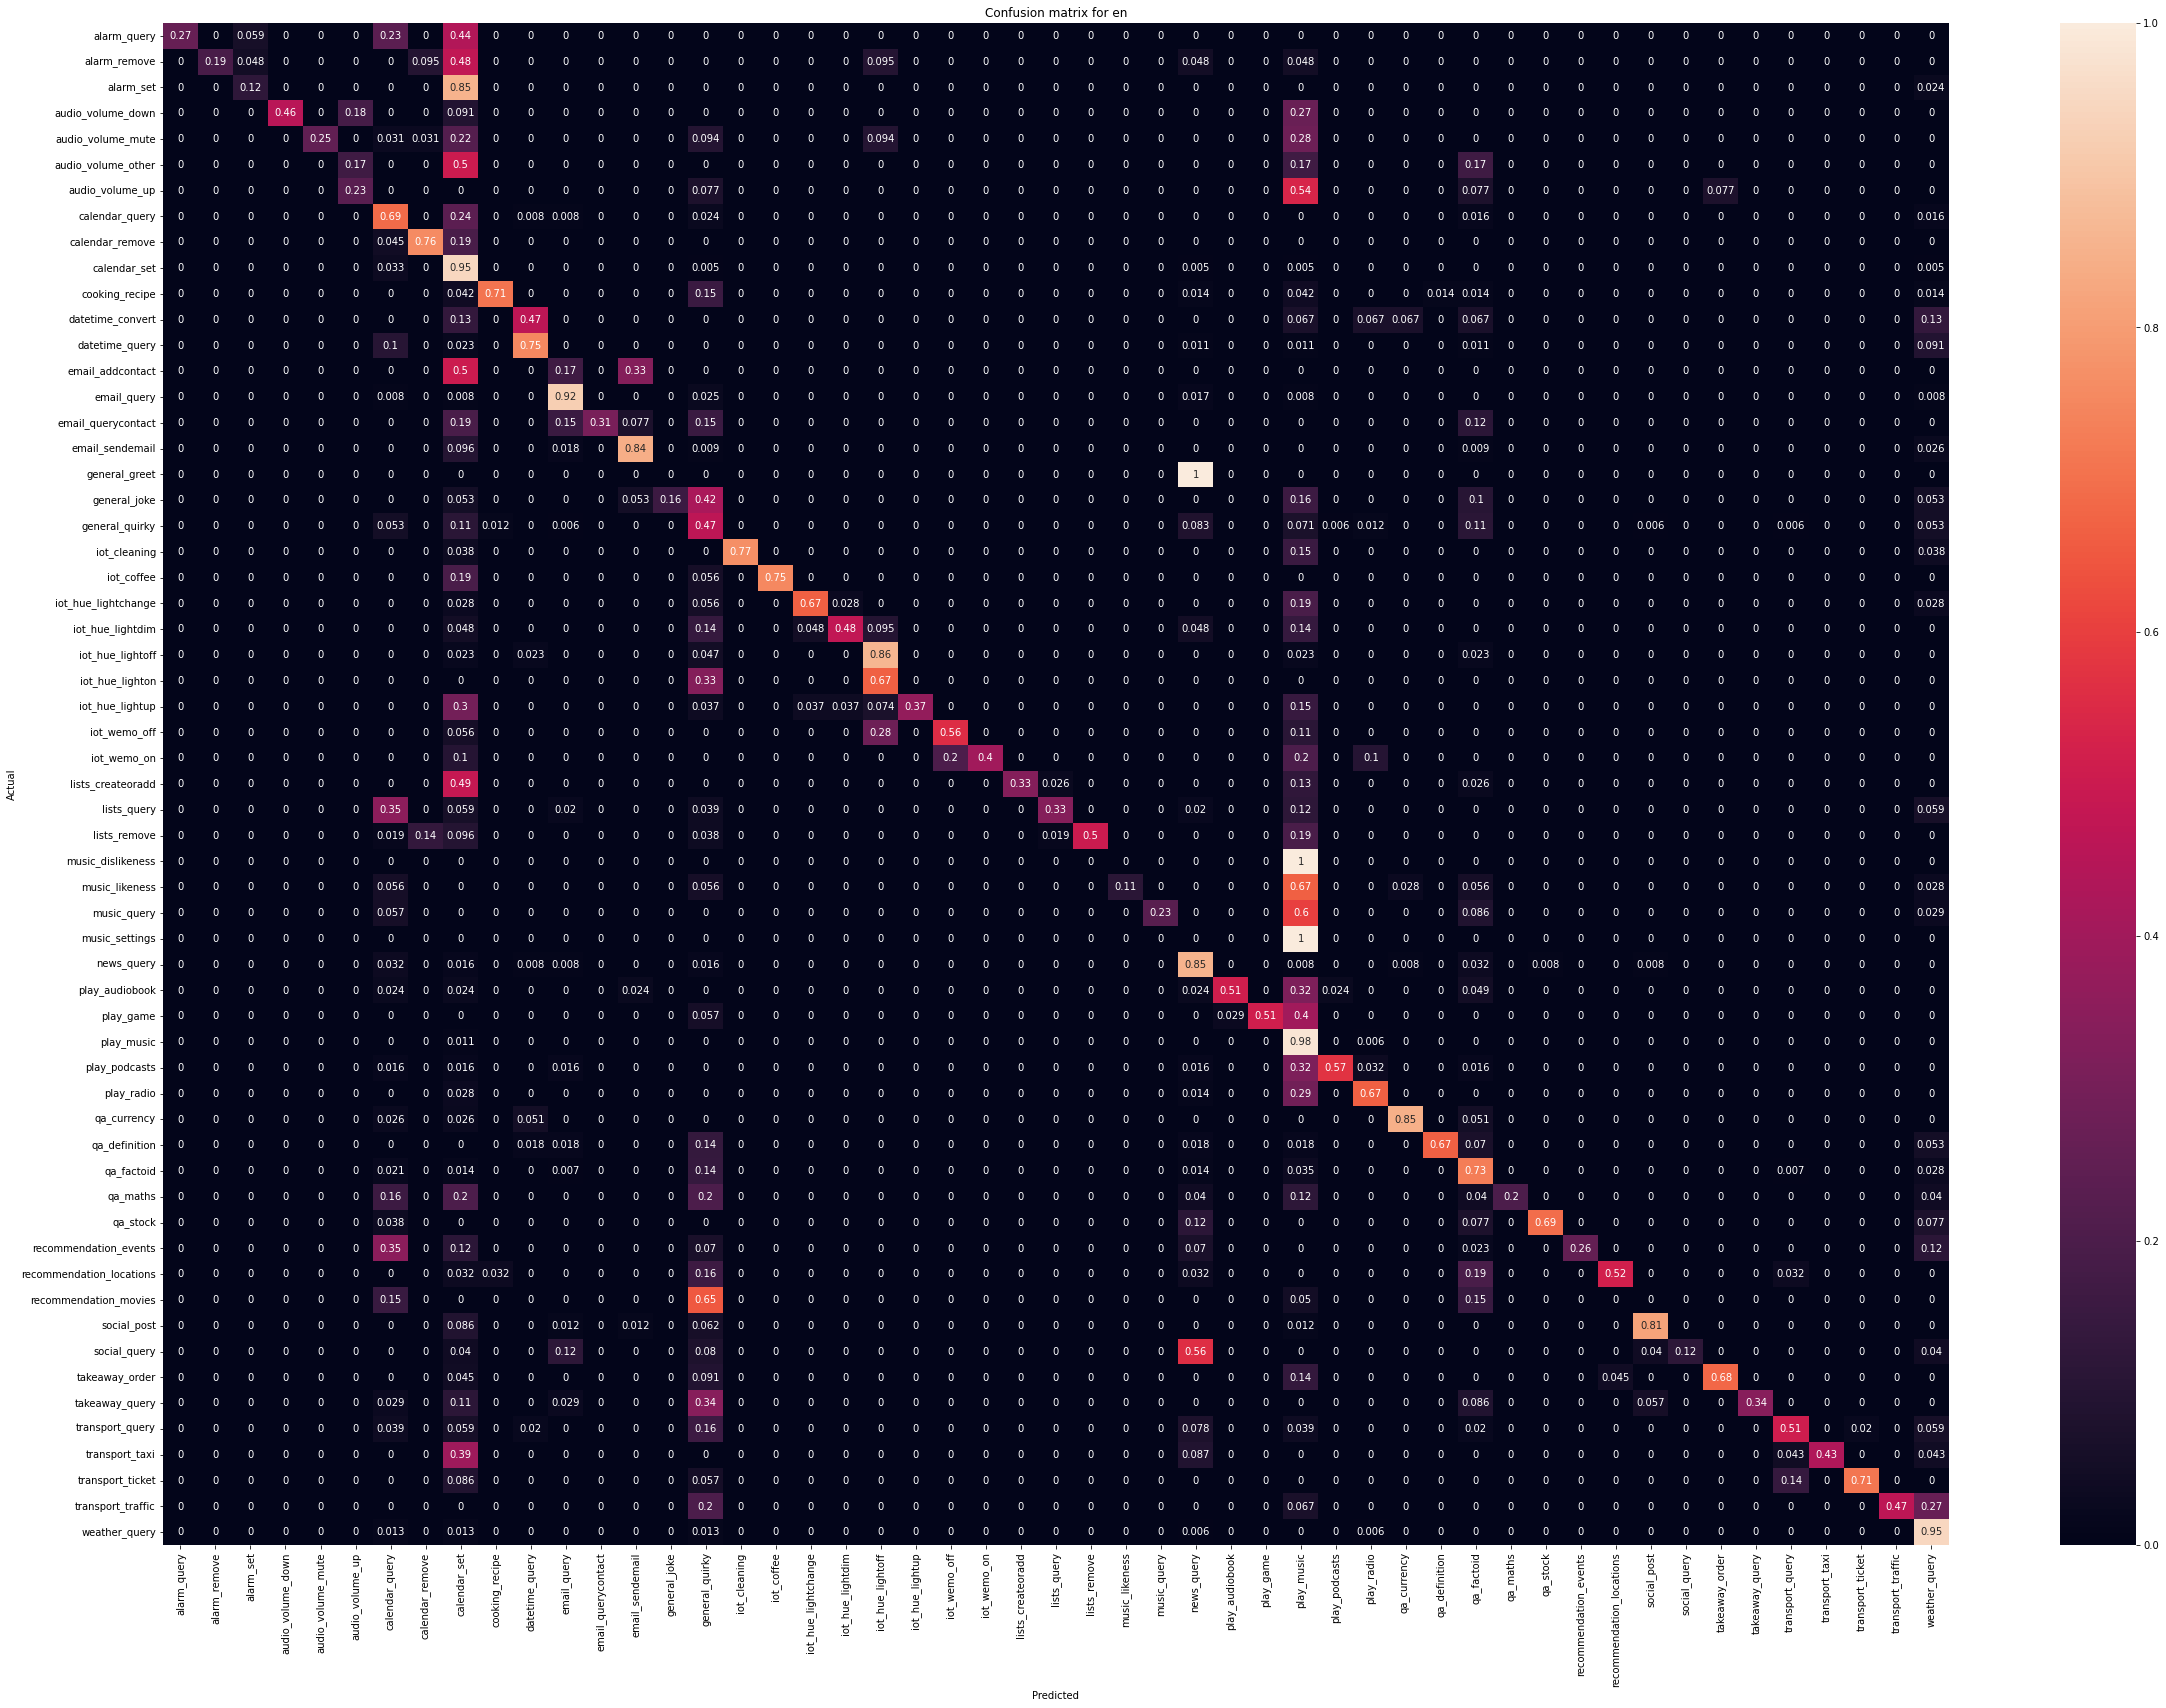

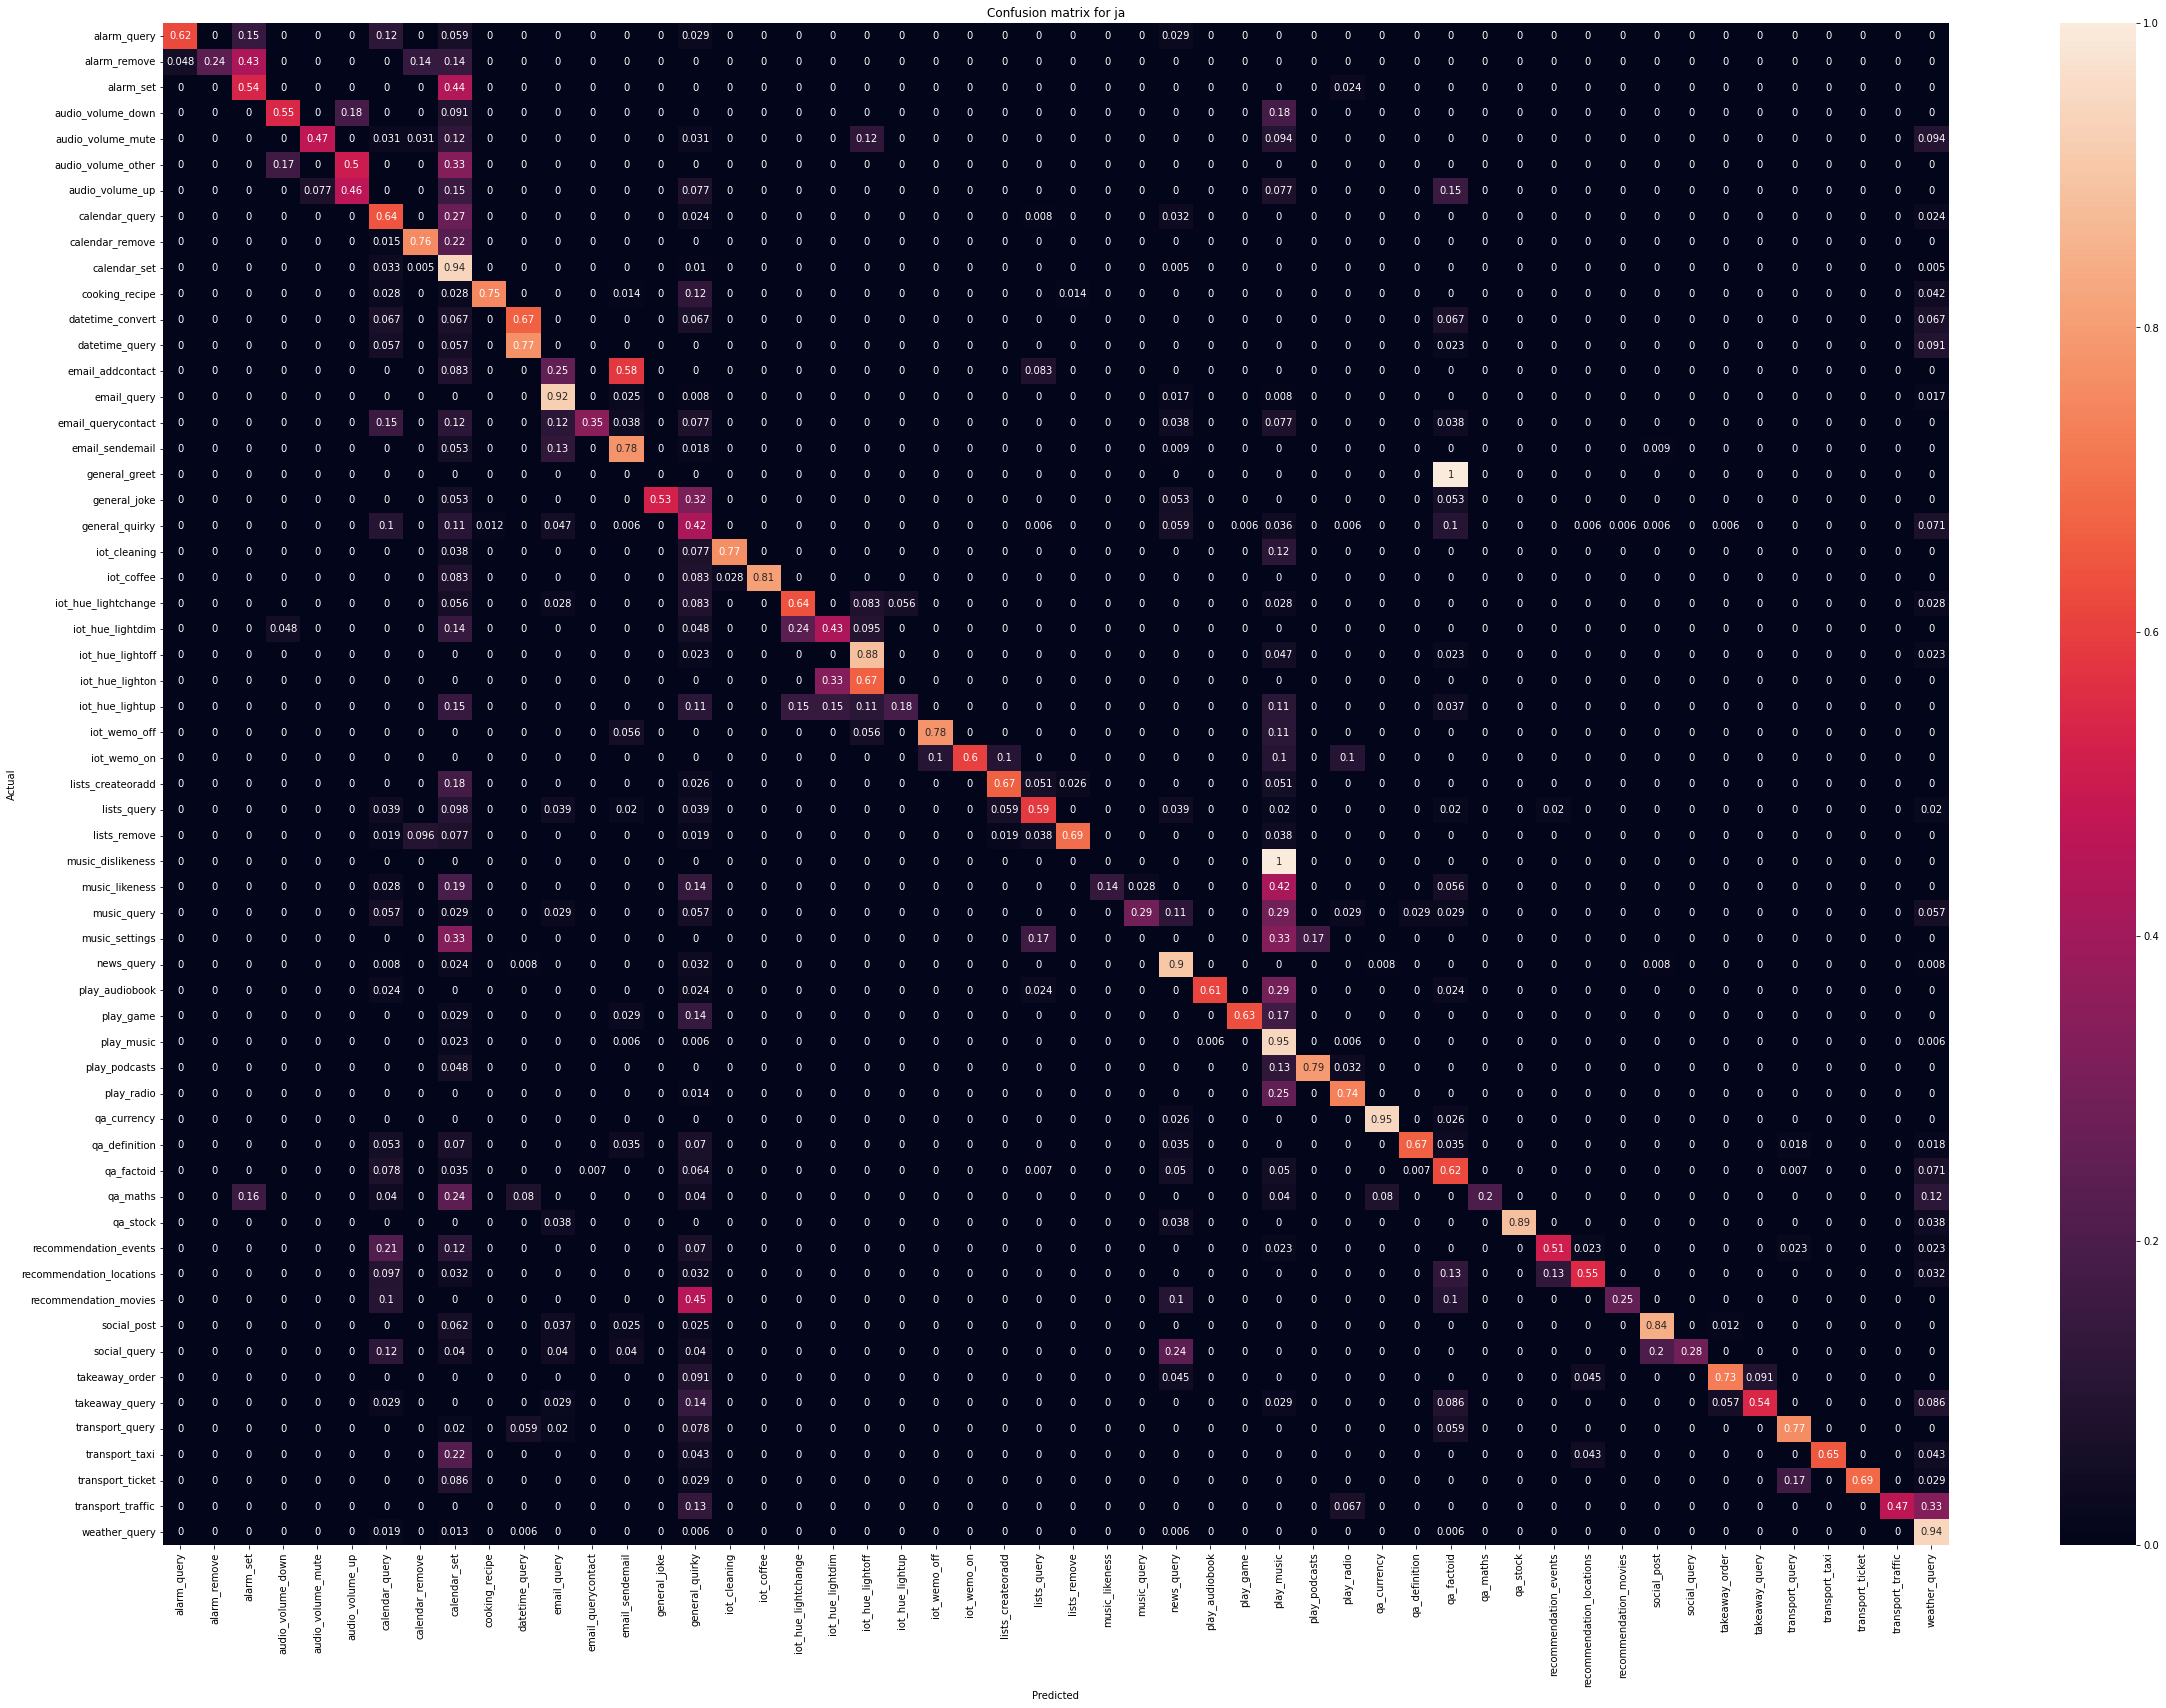

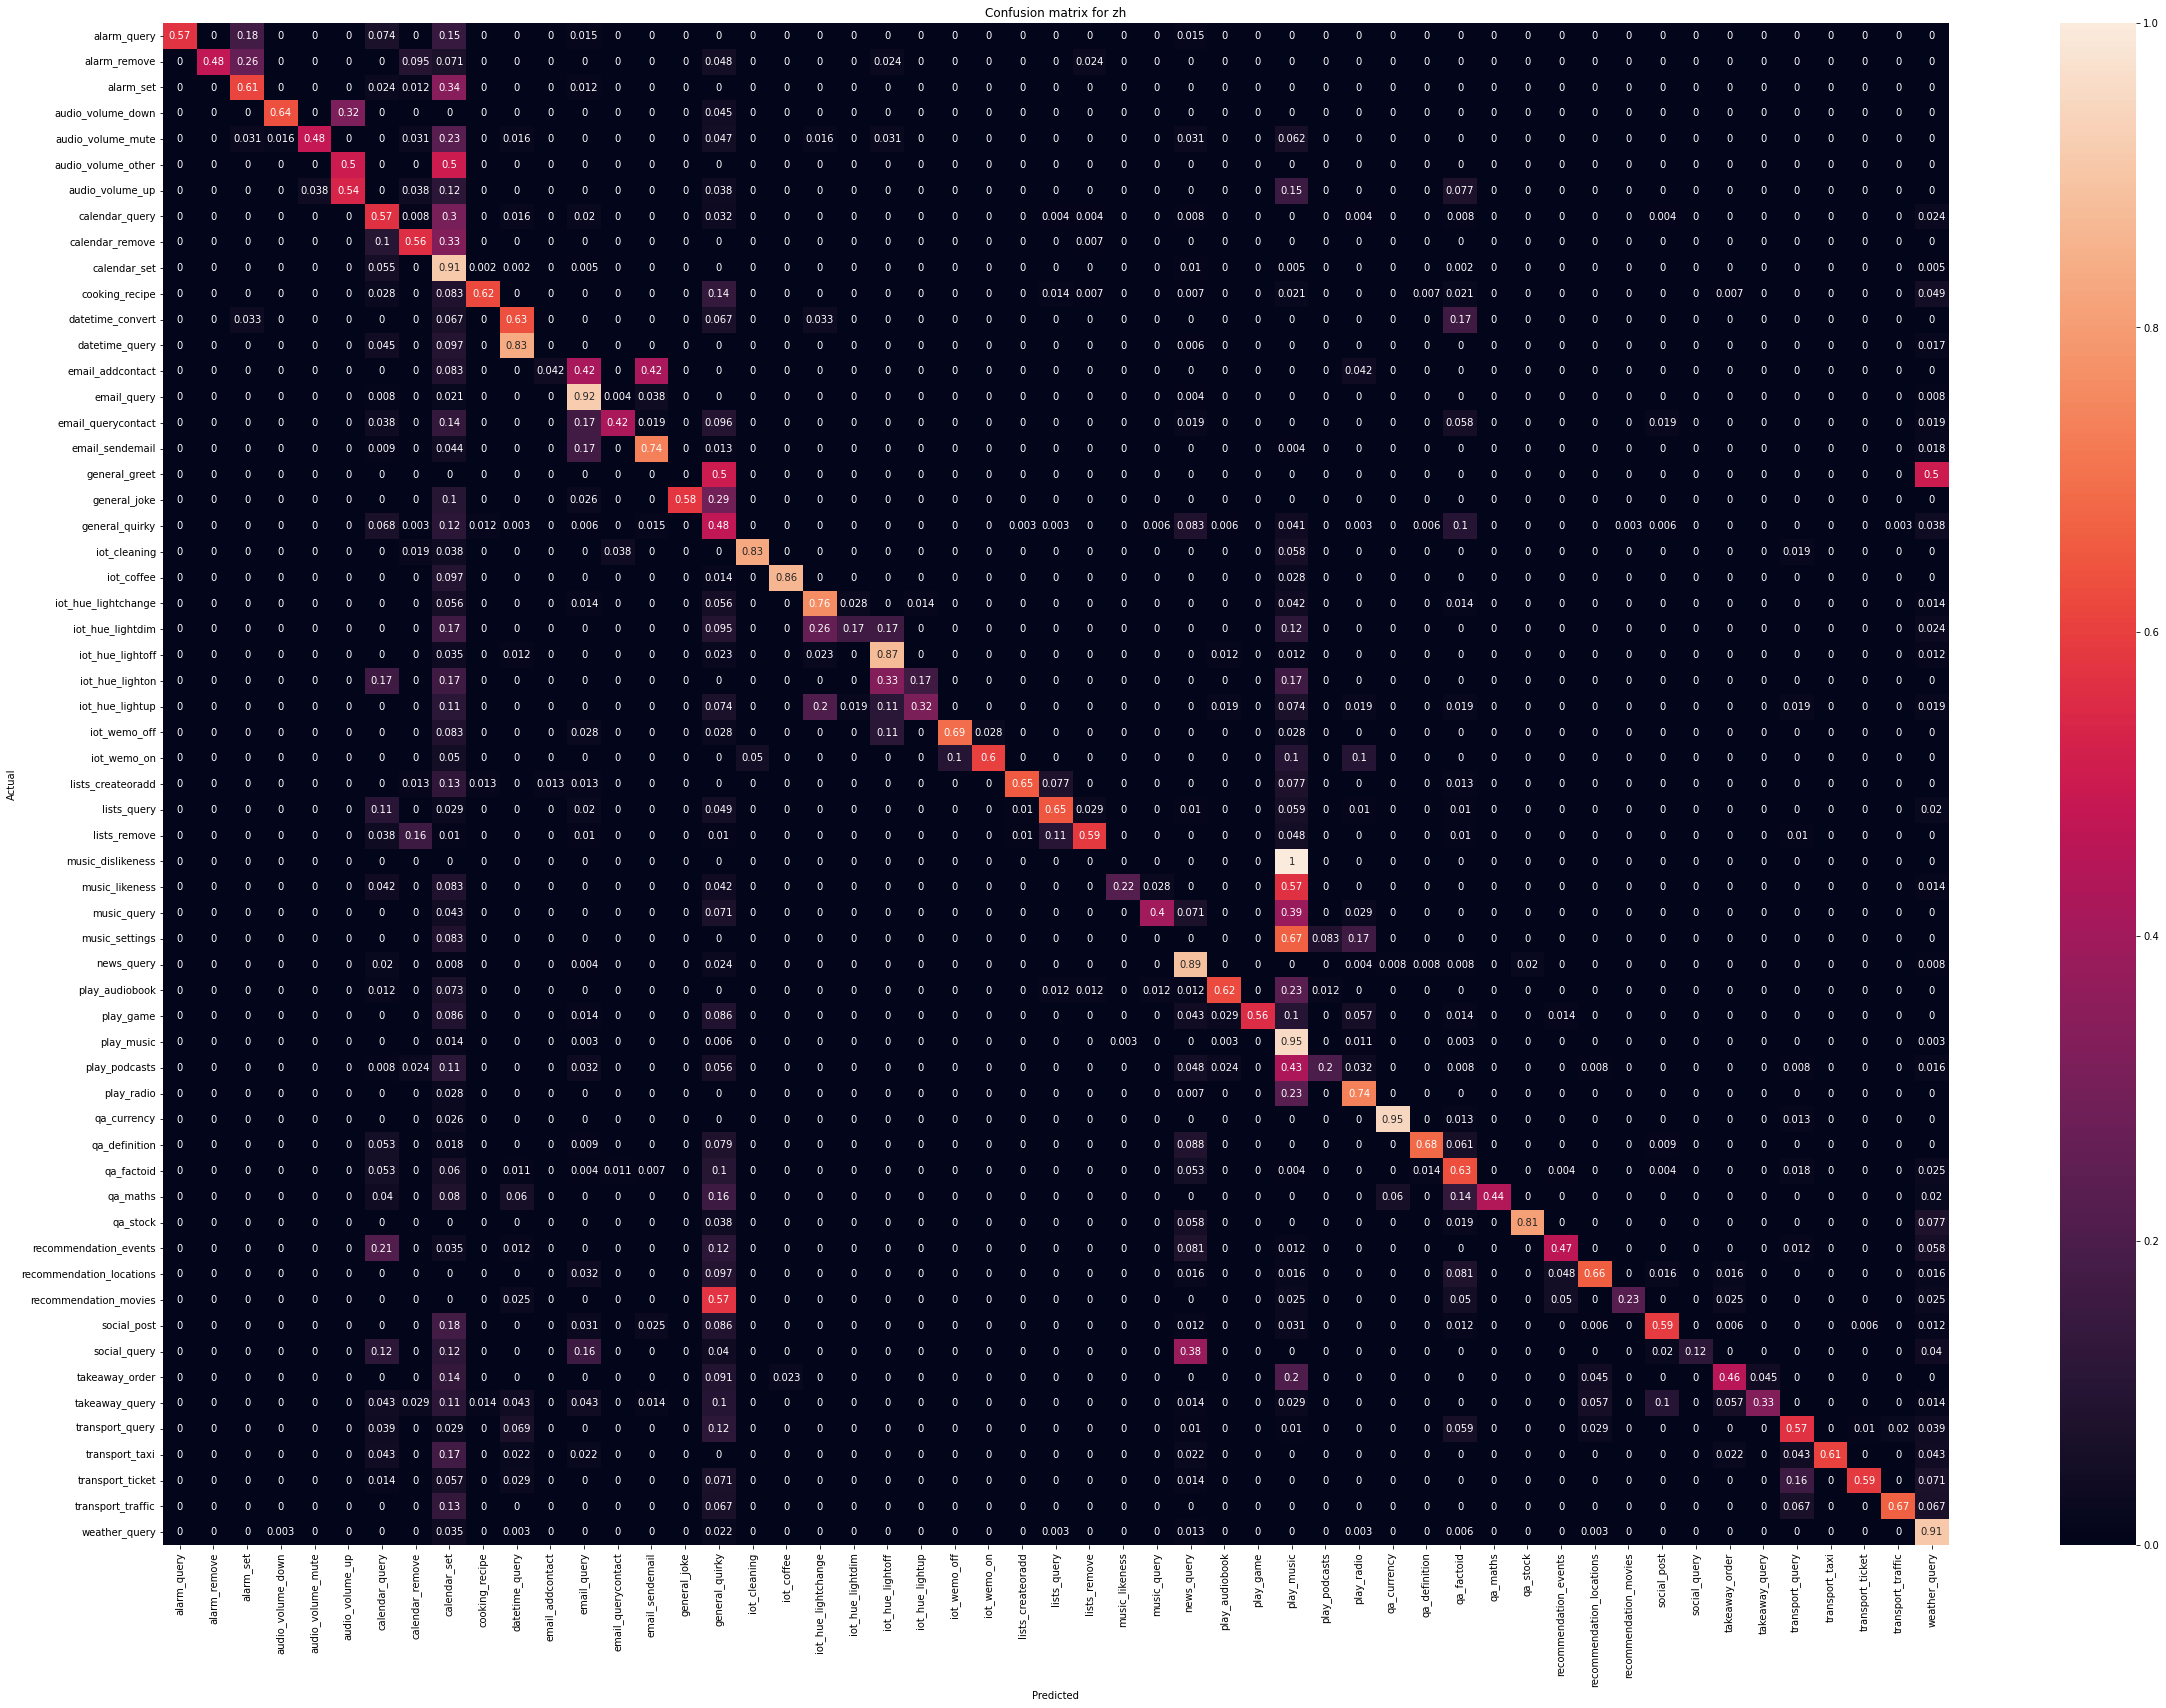

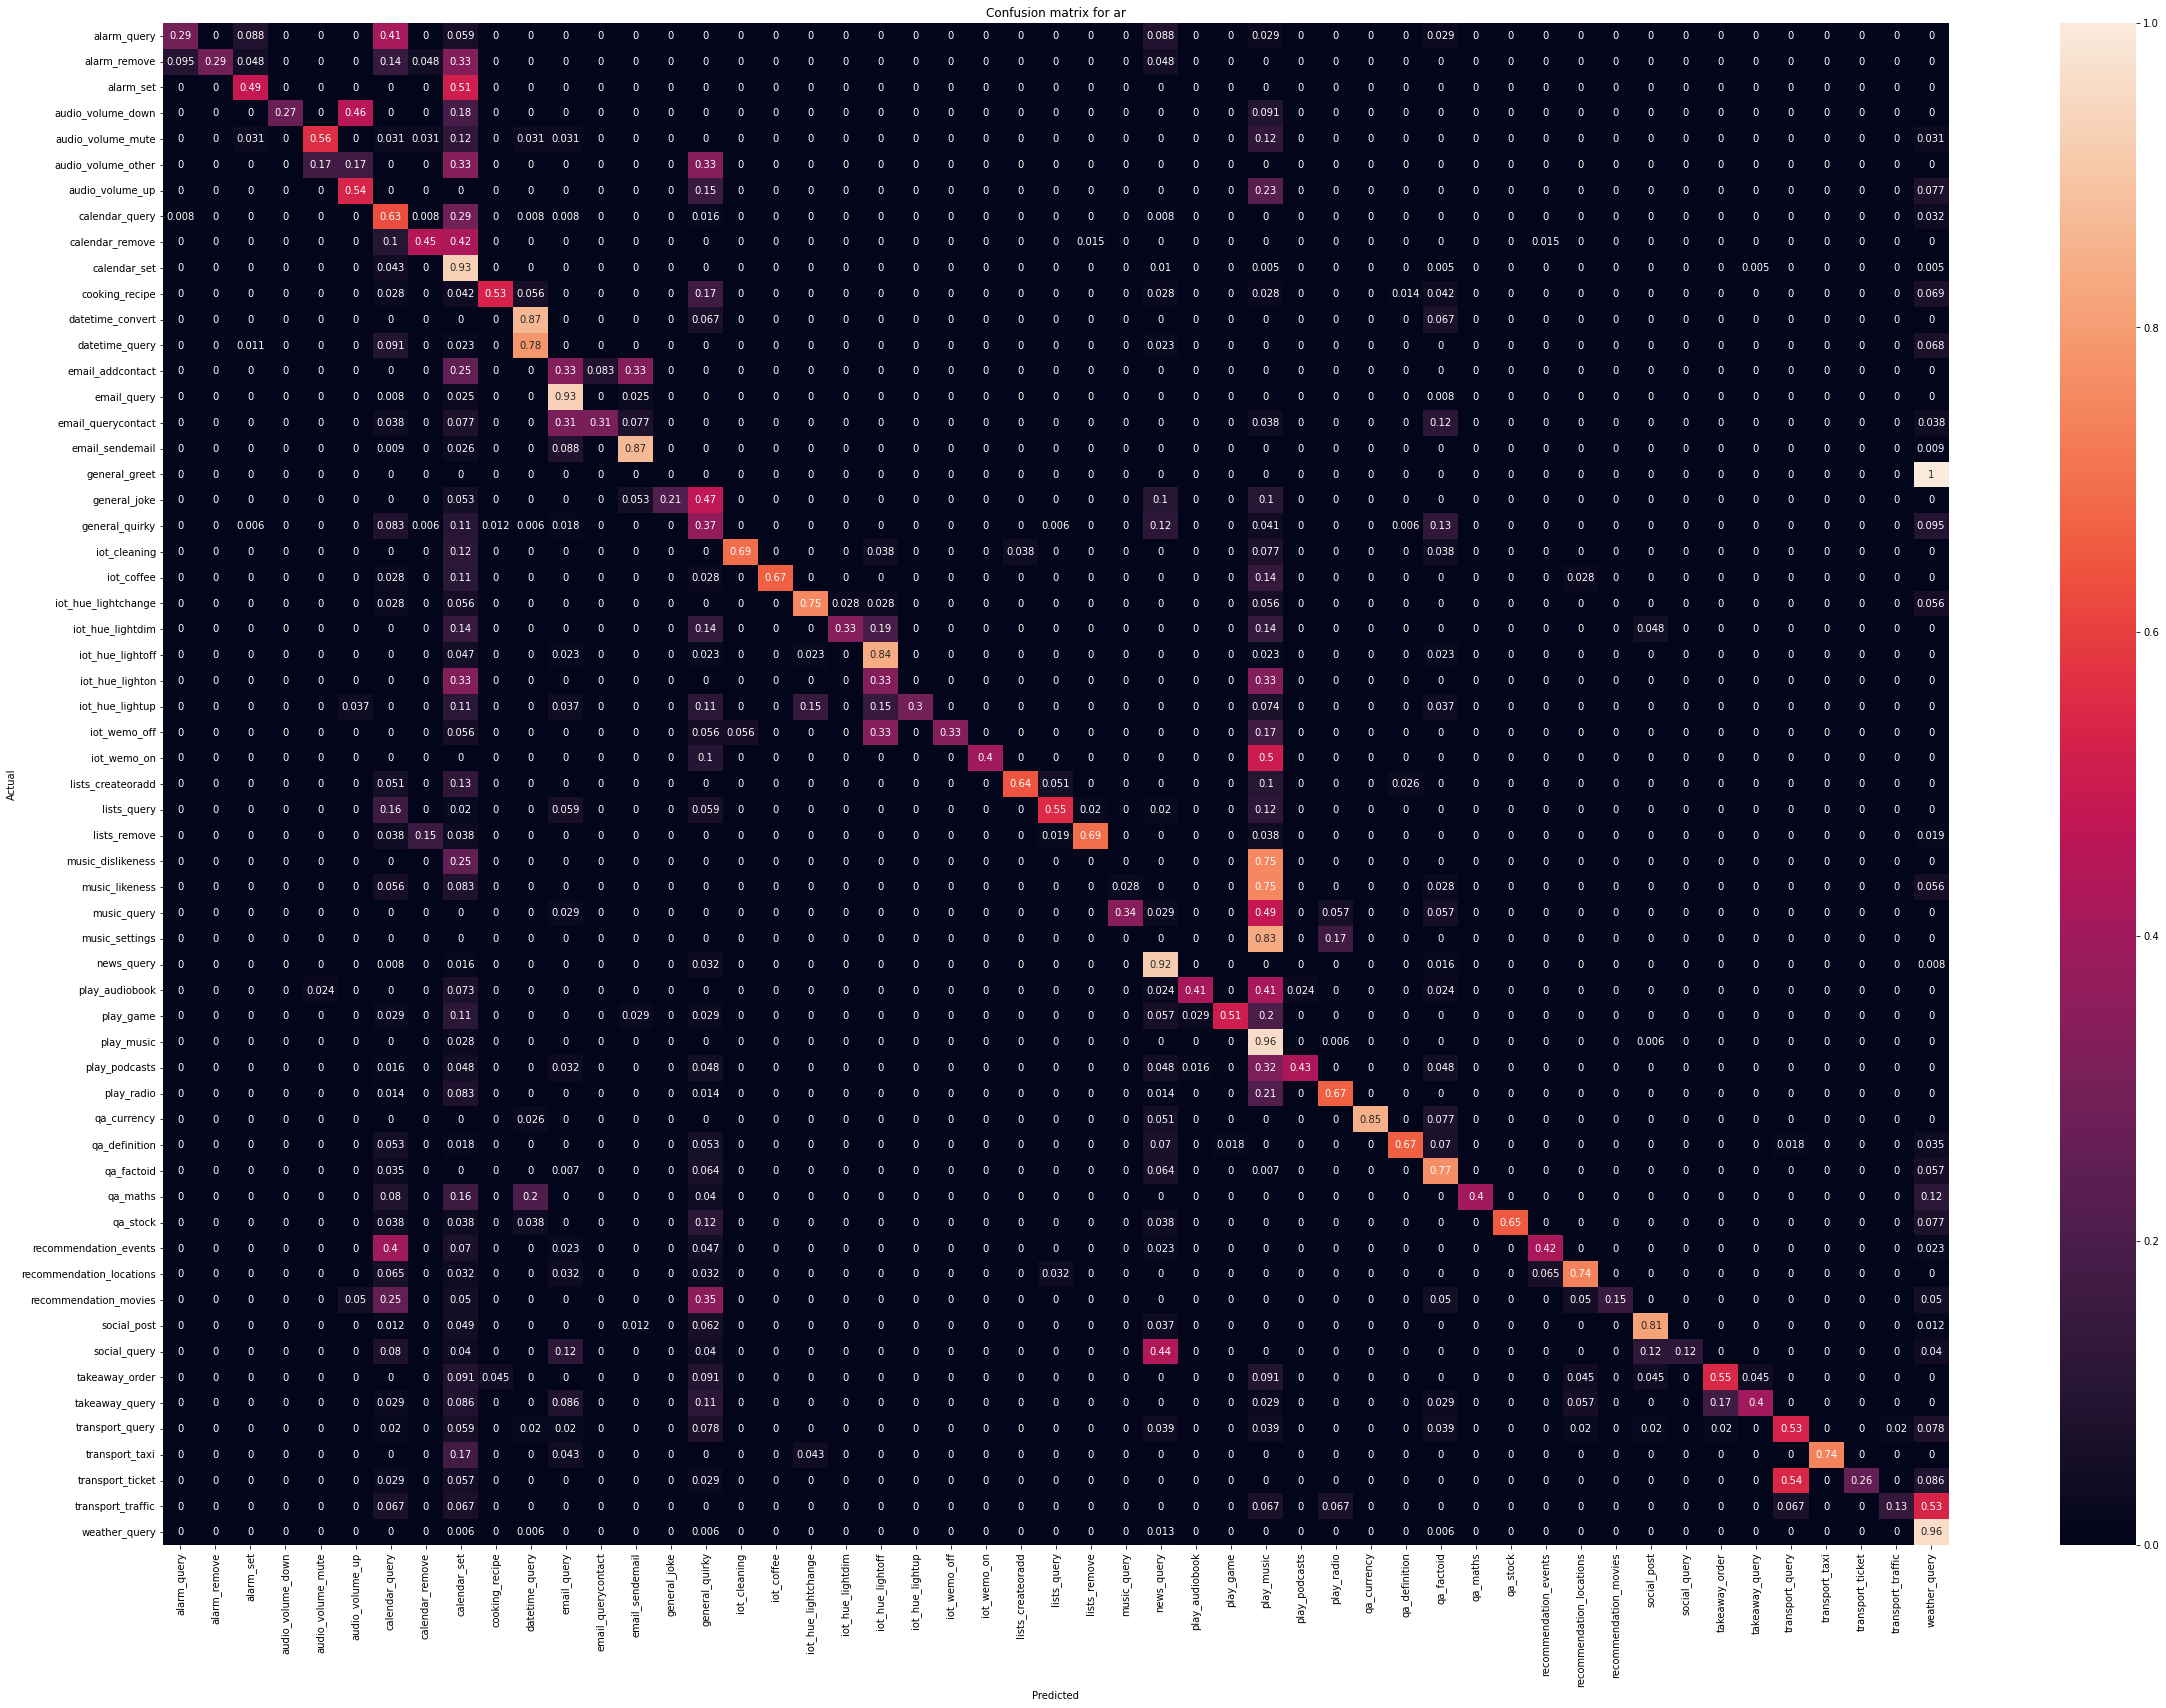

In [13]:
evaluate_model(nb, testing_inputs, testing_classes, encoder, indices)


In [14]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(subsample=0.7, n_estimators=200, min_child_weight=3, max_depth=3, max_delta_step=1, learning_rate=0.05, gamma=0.5, booster='gblinear')

xgboost.fit(training_inputs, training_classes)

[22:13:34] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "gamma", "max_delta_step", "max_depth", "min_child_weight", "subsample" } are not used.



XGBClassifier(base_score=None, booster='gblinear', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=3, max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

Evaluation metrics for XGBClassifier
XGBClassifier's default score metric: 0.7433970225615465
Classification report
              precision    recall  f1-score   support

           0     0.8362    0.7803    0.8073      1734
           1     0.8048    0.7470    0.7748      1071
           2     0.6982    0.8121    0.7508      2091
           3     0.7566    0.8200    0.7870       561
           4     0.7815    0.7714    0.7764      1632
           5     0.6852    0.3627    0.4744       306
           6     0.5812    0.7179    0.6424       663
           7     0.5712    0.6552    0.6103      6426
           8     0.7634    0.8423    0.8009      3417
           9     0.7565    0.7949    0.7752     10659
          10     0.0000    1.0000    0.0000         0
          11     0.8741    0.7391    0.8009      3672
          12     0.6448    0.5791    0.6102       765
          13     0.7713    0.8393    0.8039      4488
          14     0.5277    0.5294    0.5285       612
          15     0.

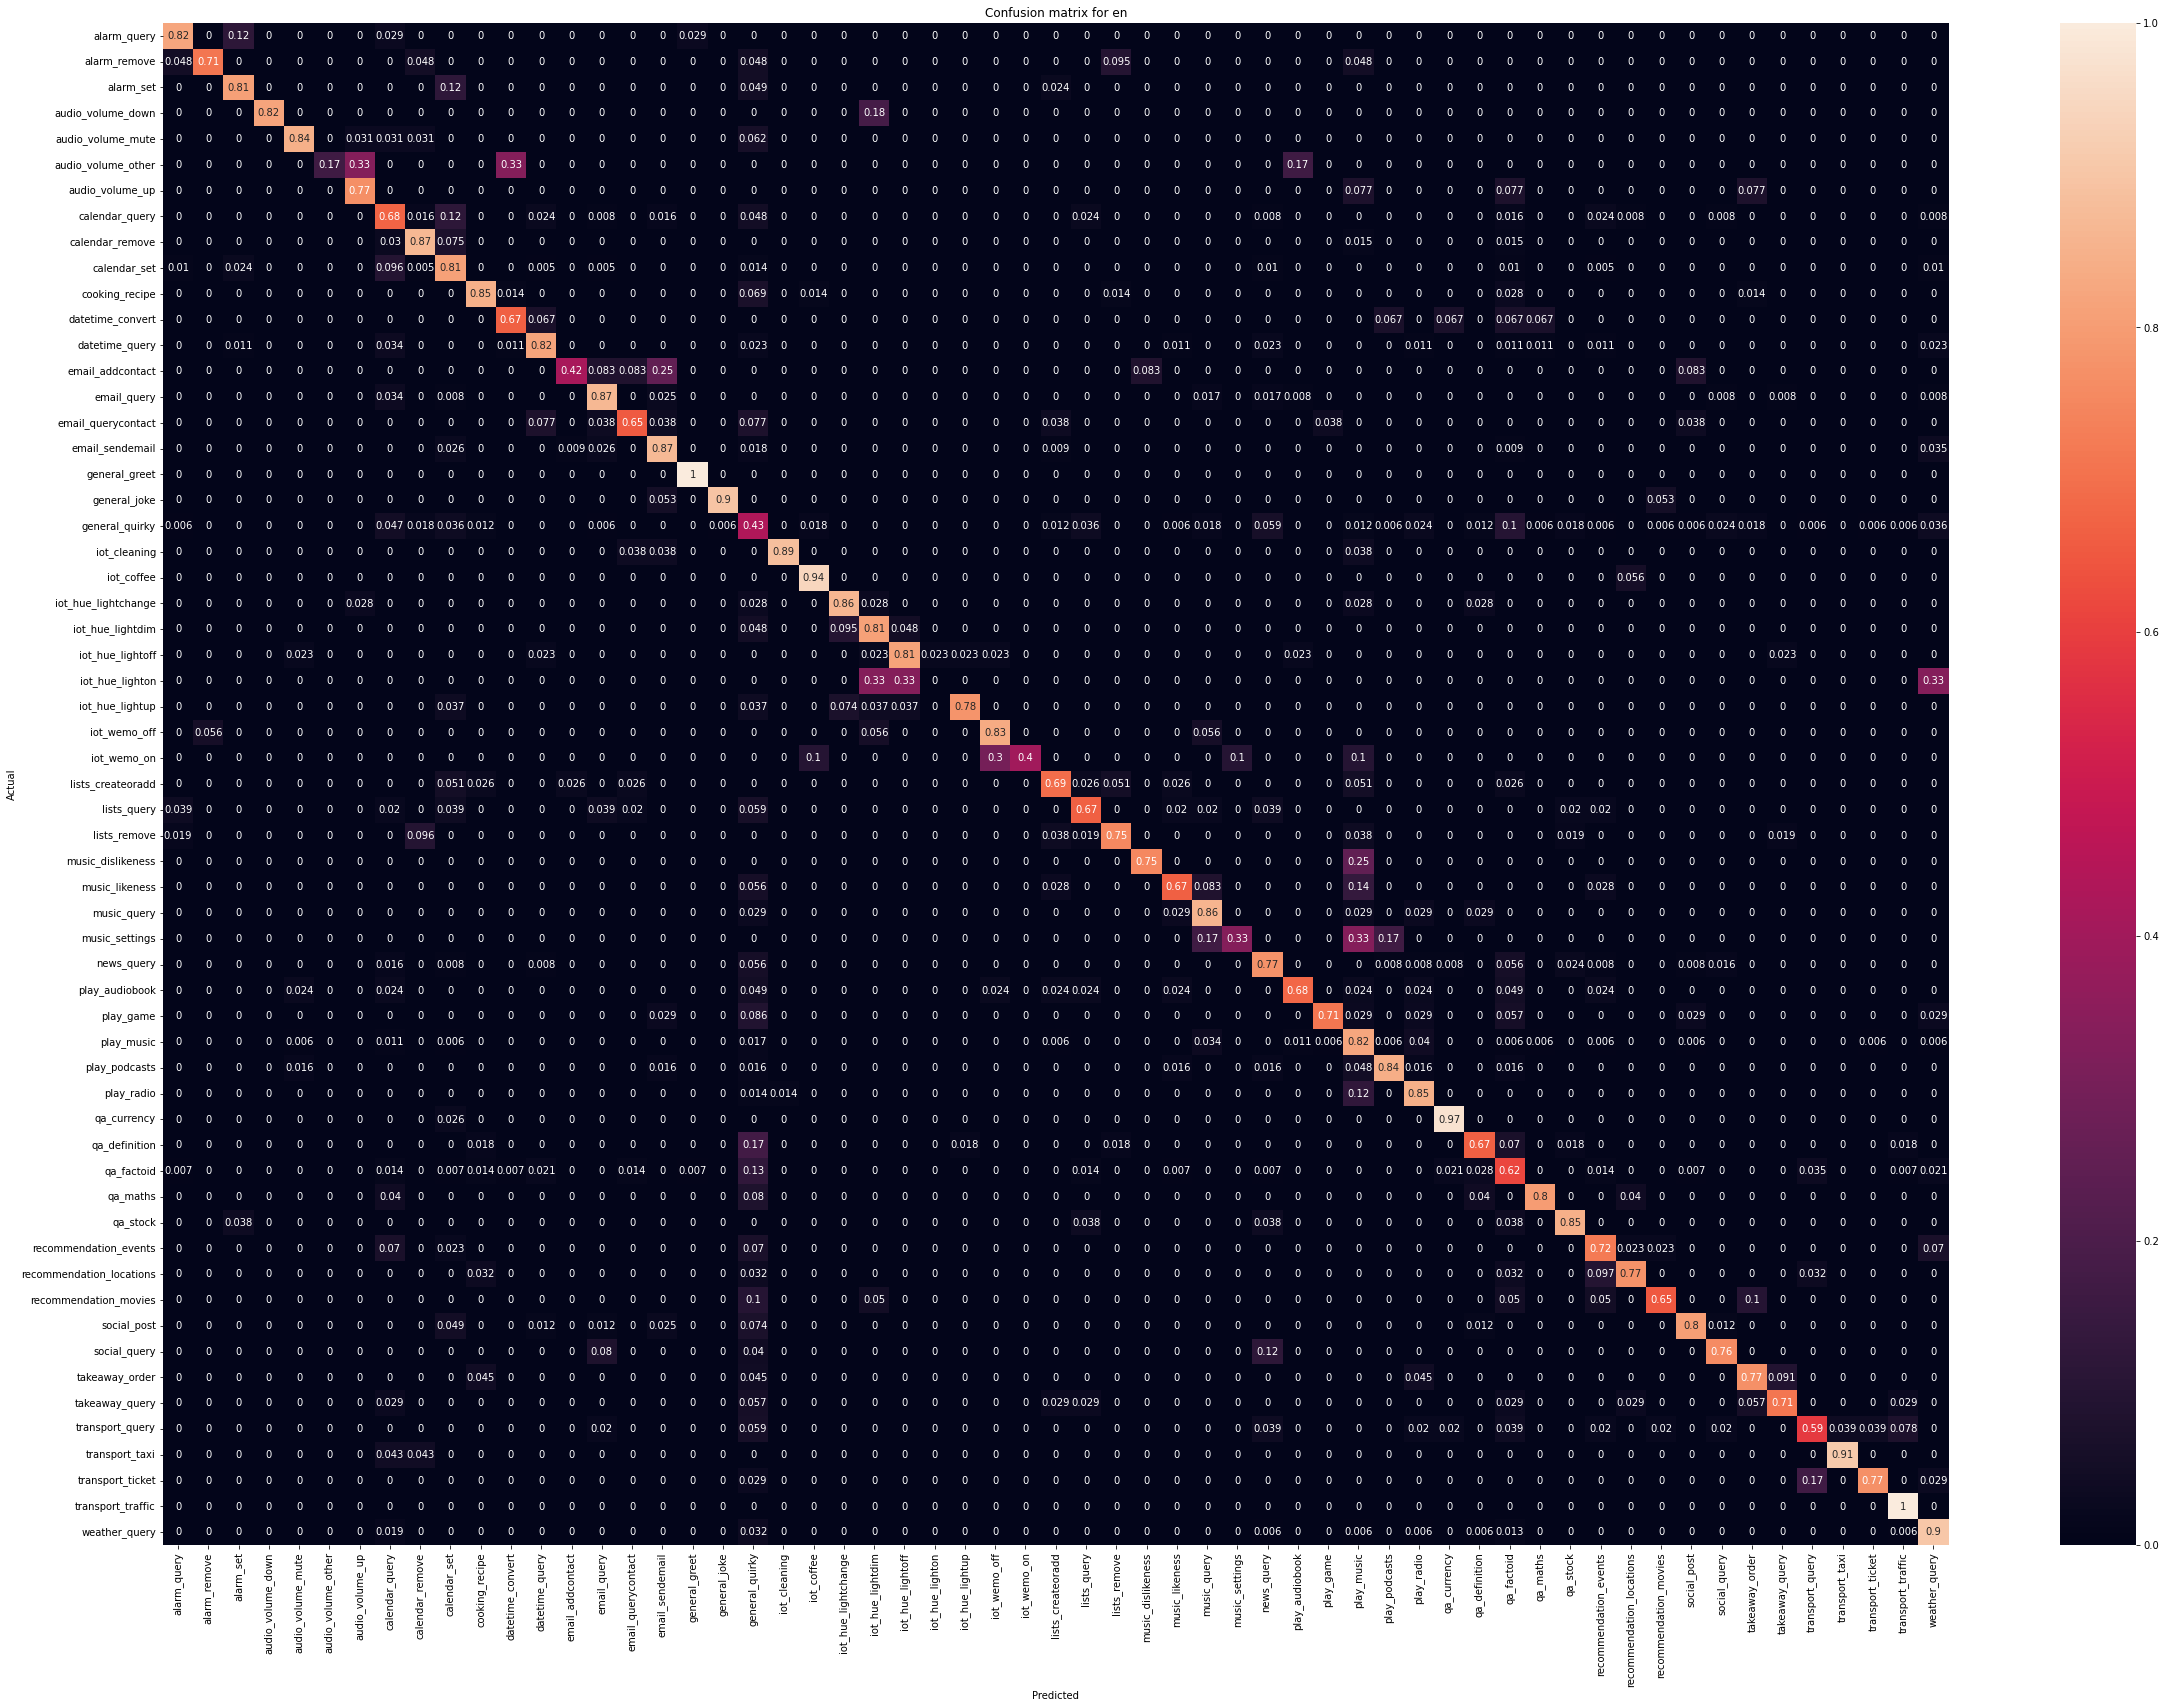

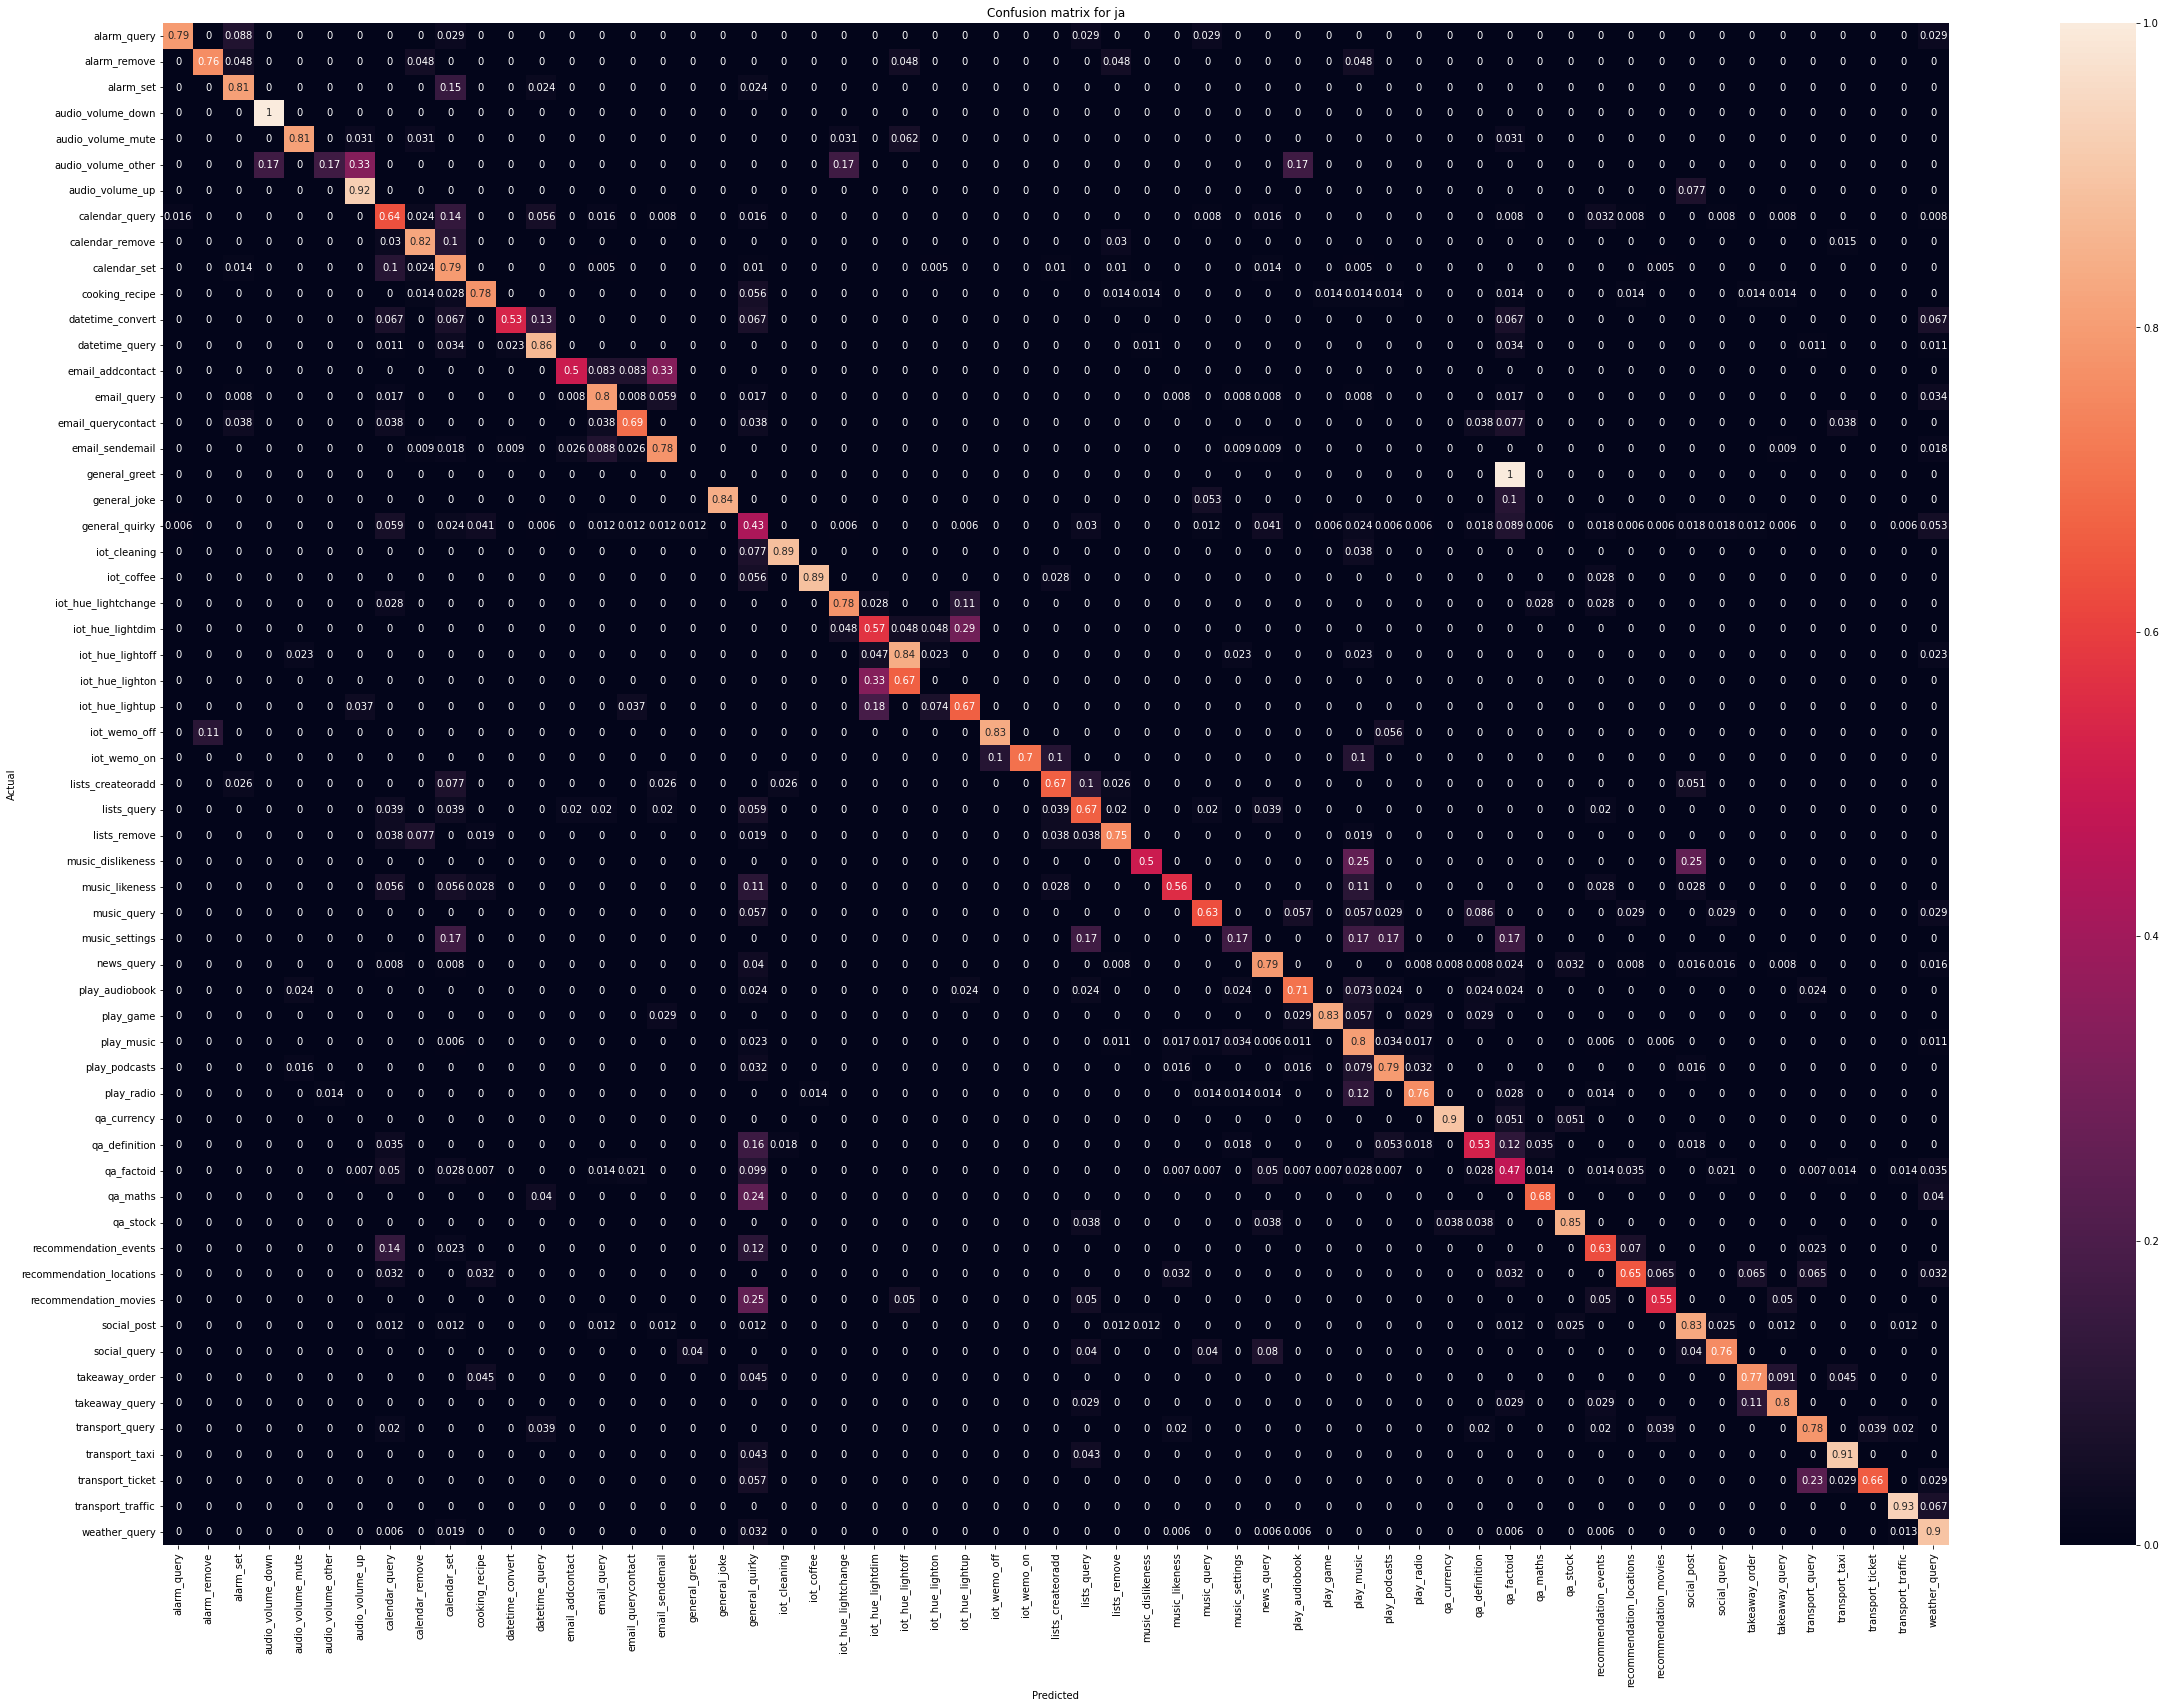

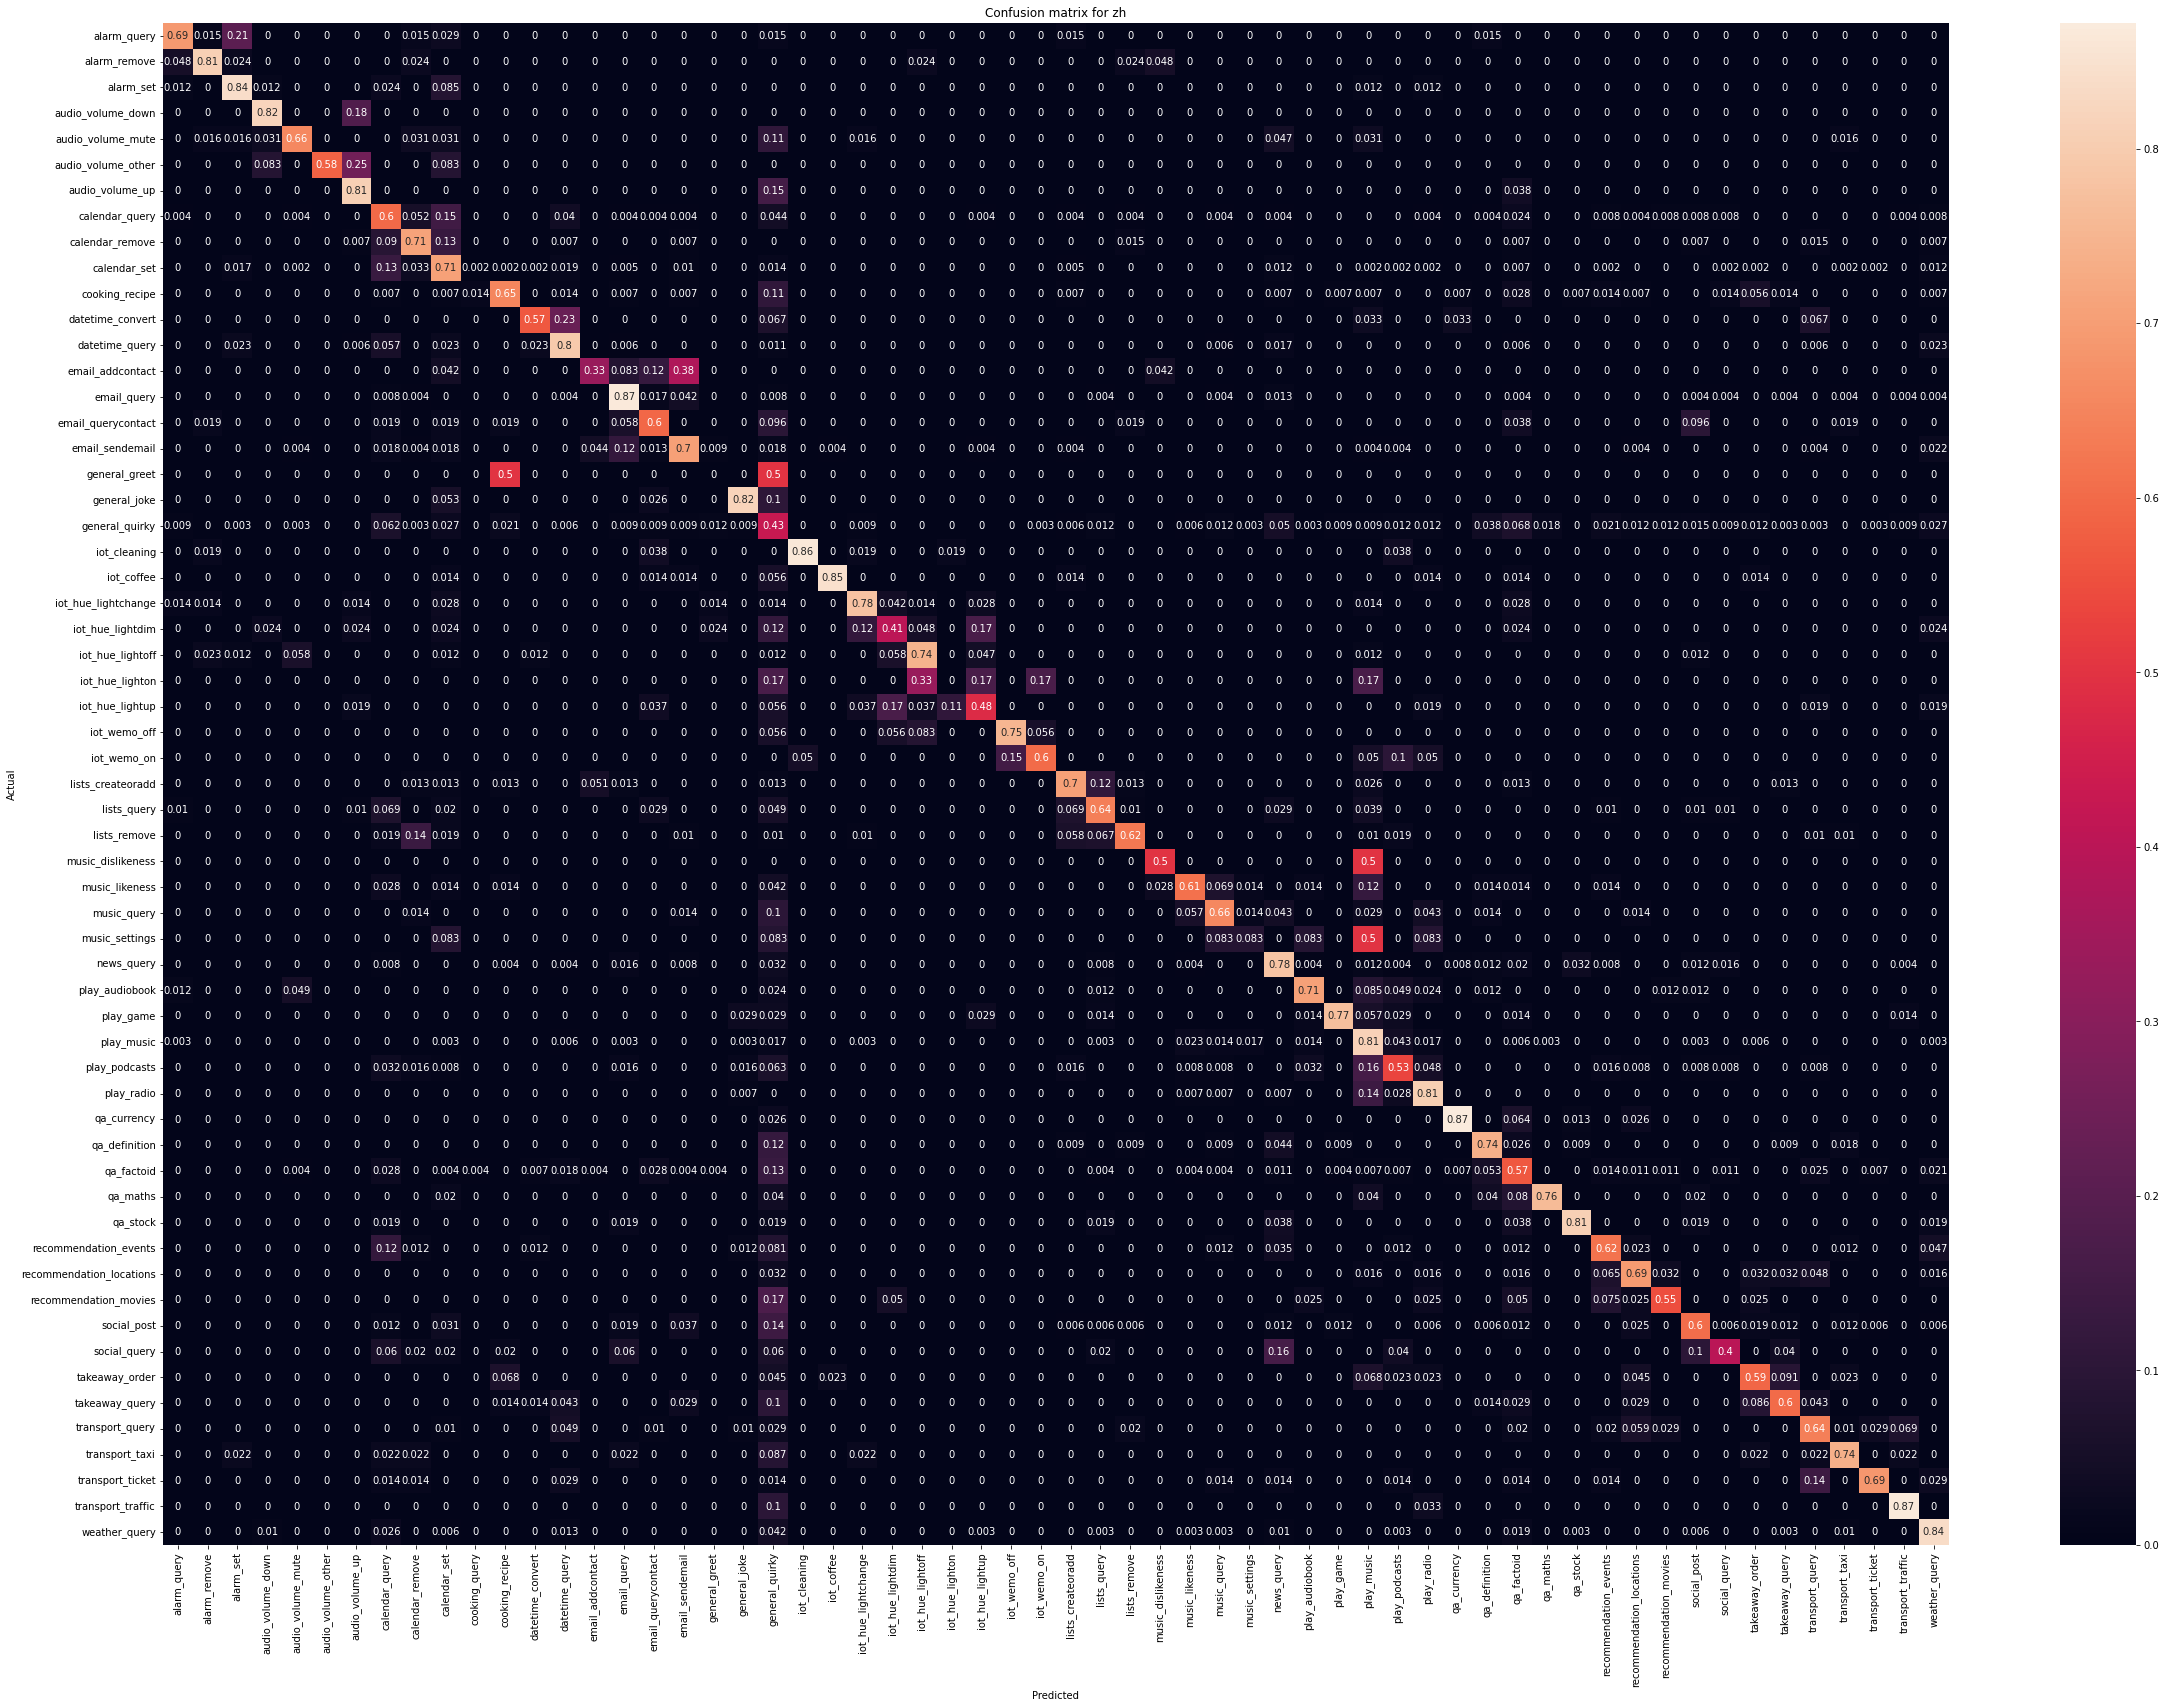

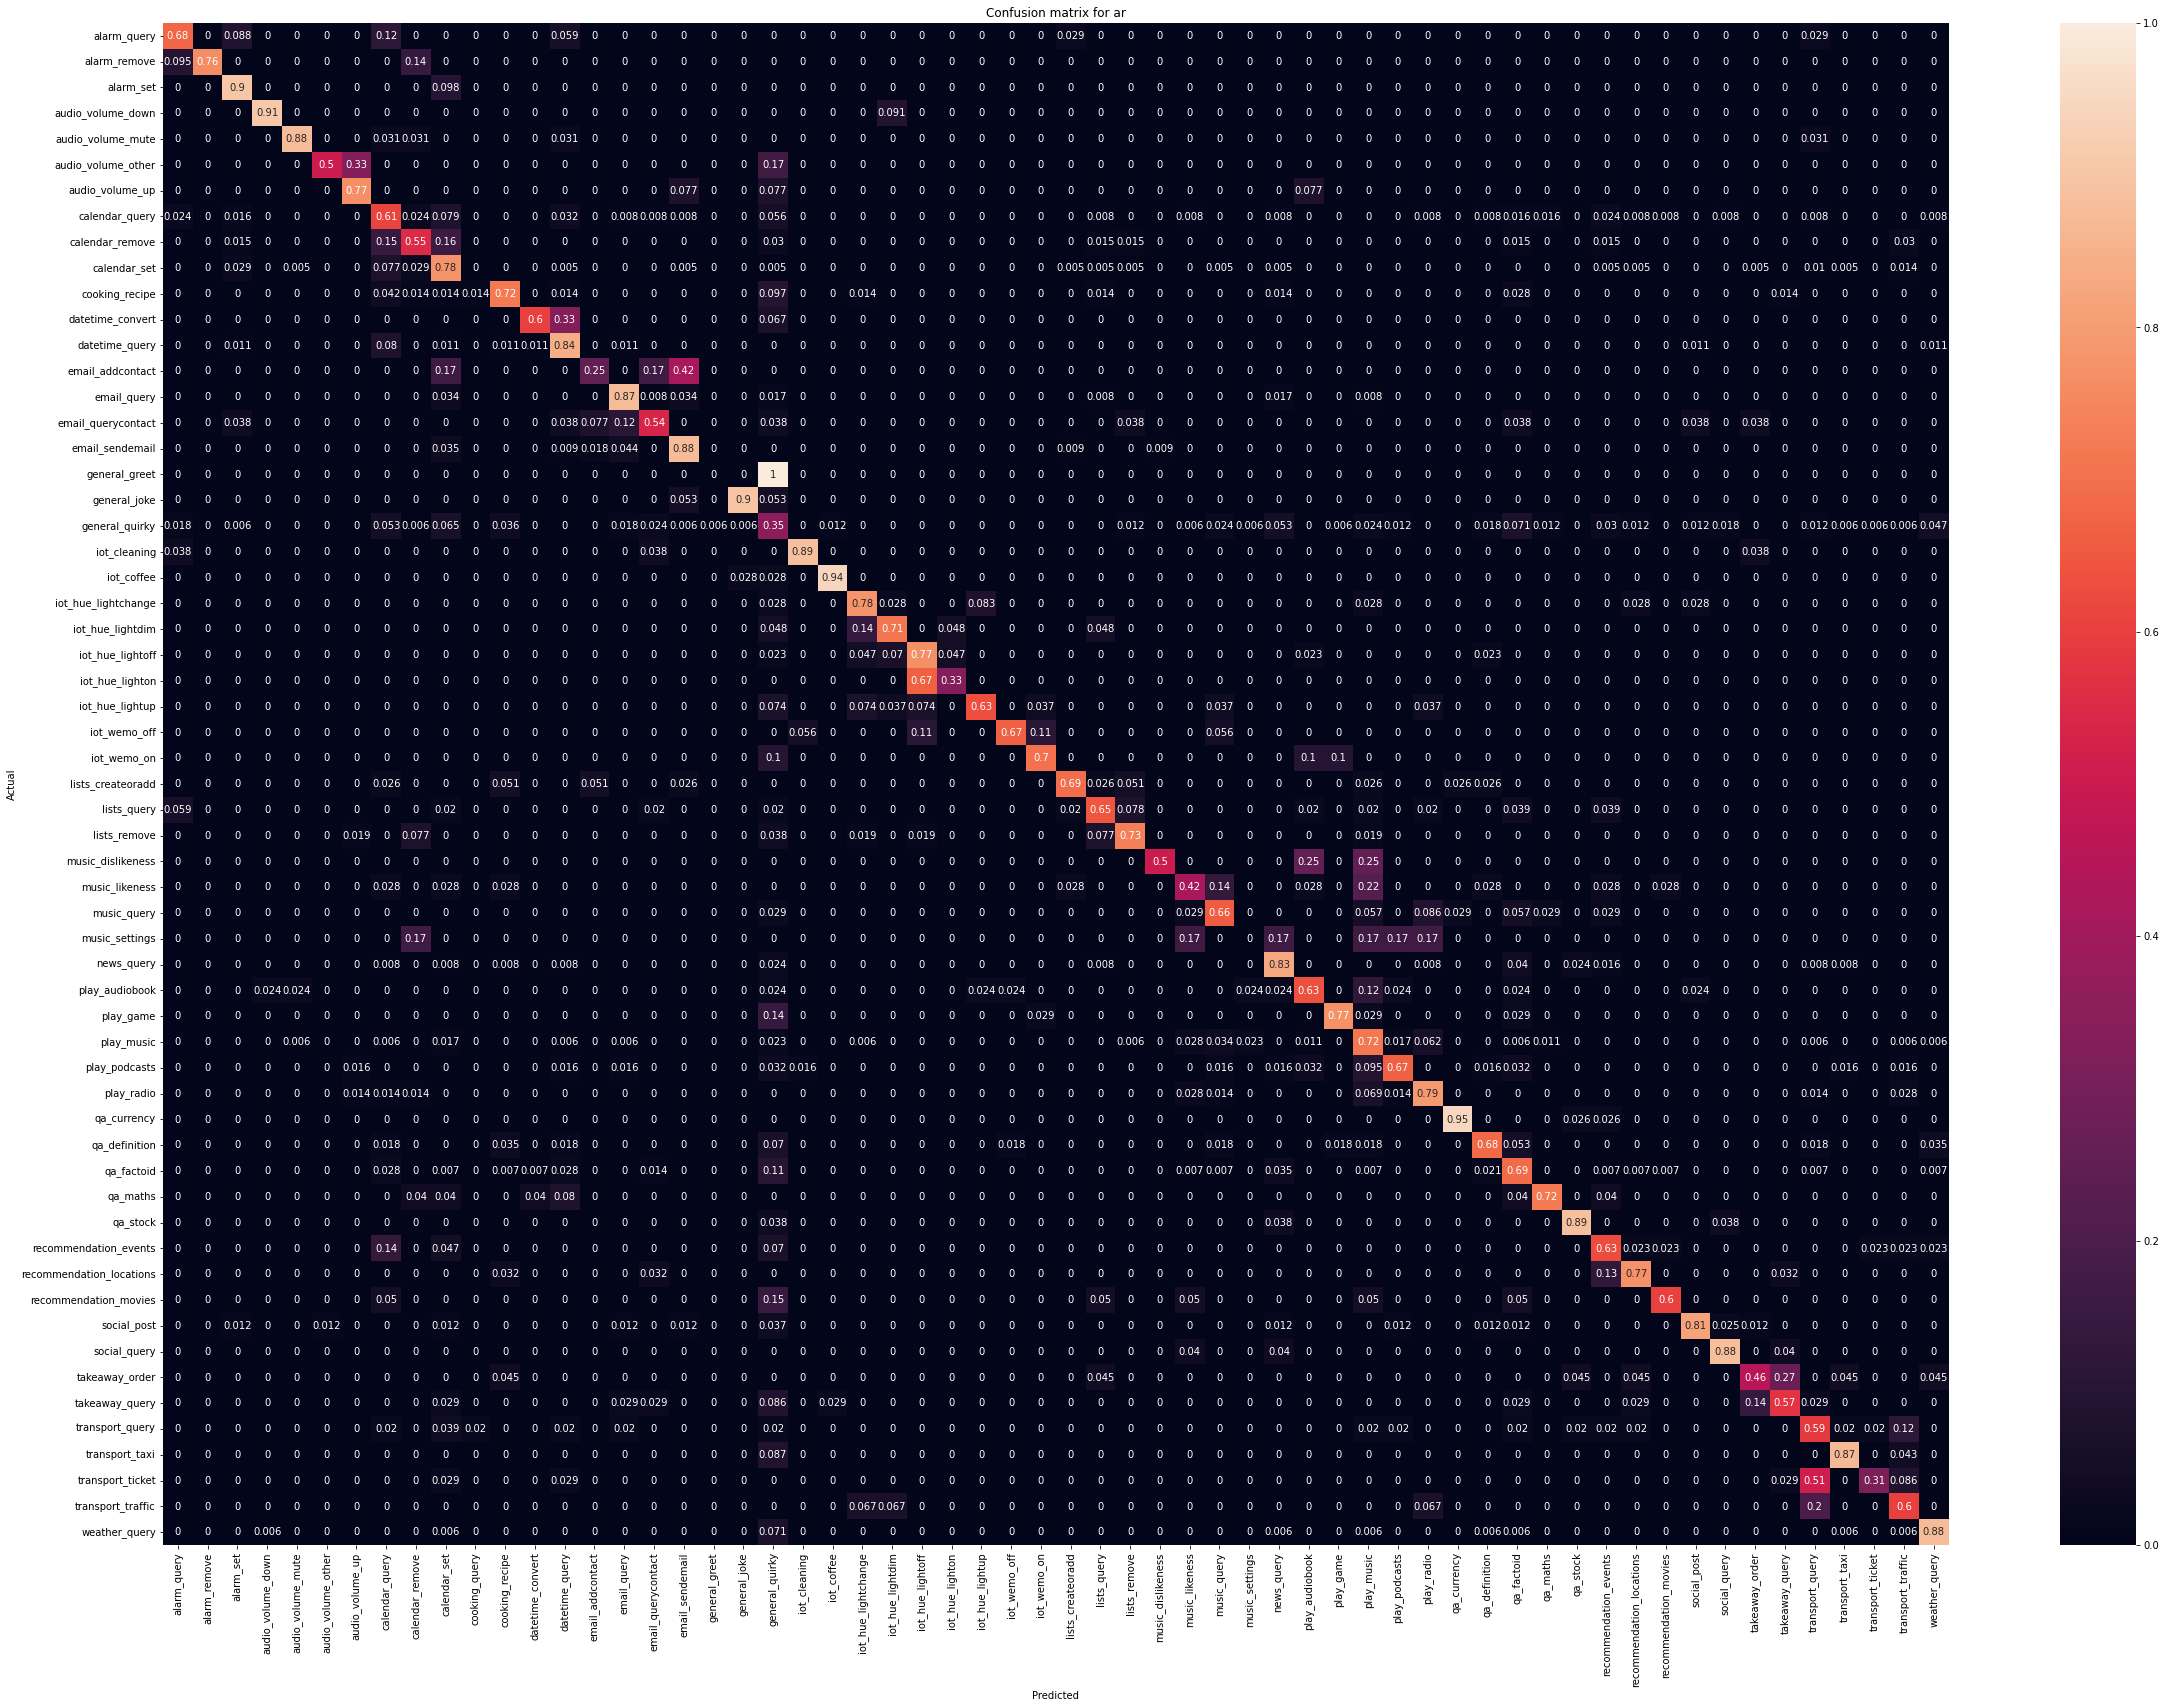

In [15]:
evaluate_model(xgboost, testing_inputs, testing_classes, encoder, indices)